In [1]:
#!pip install requirements.txt

In [ ]:
#!bash load_data.sh

Здесь реализован на чистом PyTorch классический подход к решению задачи NER как задачи разметки последовательности, подробно описанный в статье https://aclanthology.org/P16-1101.pdf . За неимением должного количества ресурсов и времени гиперпараметры были взяты из статьи https://arxiv.org/pdf/1511.08308v5.pdf , а голова была заменена на Softmax. В качестве эмбеддинга используется GLOVE (размерностью 50).

In [1]:
import os, sys

In [2]:
sys.path.append(os.path.join(os.getcwd(), 'ner'))

In [3]:
import torch

In [4]:
USE_GPU = torch.cuda.is_available()

In [5]:
USE_GPU = False

In [6]:
PATH_TO_TRAIN = './conll2003/train.txt'
PATH_TO_TEST = './conll2003/test.txt'
PATH_TO_VALID = './conll2003/valid.txt'

In [7]:
from ner.data_utils import load_sentences, iter_over_sentences, iter_over_words, iter_over_tags, create_mapping

In [8]:
train_sentences = load_sentences(PATH_TO_TRAIN)
test_sentences = load_sentences(PATH_TO_TEST)
valid_sentences = load_sentences(PATH_TO_VALID)

In [9]:
word_to_id, id_to_word = create_mapping(train_sentences, iter_over_sentences)
char_to_id, id_to_char = create_mapping(train_sentences, lambda s: iter_over_words(s, True))
raw_char_to_id, id_to_raw_char = create_mapping(train_sentences, iter_over_words)
tag_to_id, id_to_tag = create_mapping(train_sentences, iter_over_tags, False)

In [10]:
from ner.datasets.ner_dataset import create_loader, NERDataset

In [11]:
train_data = NERDataset(train_sentences, word_to_id, char_to_id, raw_char_to_id, tag_to_id)
test_data = NERDataset(test_sentences, word_to_id, char_to_id, raw_char_to_id, tag_to_id)
valid_data = NERDataset(valid_sentences, word_to_id, char_to_id, raw_char_to_id, tag_to_id)

100%|██████████| 3466/3466 [00:00<00:00, 4995.72it/s]


In [12]:
train_dataloader = create_loader(train_data, shuffle=True, use_gpu=USE_GPU)
test_dataloader = create_loader(test_data, use_gpu=USE_GPU)
valid_dataloader = create_loader(valid_data, use_gpu=USE_GPU)

In [13]:
from ner.model_utils import load_embeddings

In [14]:
WORDS_DIMENTION = 50
PATH_TO_EMBEDDING = f'./glove.6B.{WORDS_DIMENTION}d.txt'

In [15]:
word_embeds = load_embeddings(PATH_TO_EMBEDDING, word_to_id, WORDS_DIMENTION)

In [16]:
from ner.models.cnn_bilstm_softmax import CNN_BiLSTM_Softmax

In [18]:
model = CNN_BiLSTM_Softmax(vocab_size=len(word_to_id),
                   tag_to_ix=tag_to_id,
                   embedding_dim=WORDS_DIMENTION,
                   hidden_dim=275,
                   char_to_ix=char_to_id,
                   raw_char_to_ix=raw_char_to_id,
                   pre_word_embeds=word_embeds,
                   char_out_dimension=53,
                   
)

if USE_GPU:
    model = model.cuda()

/Users/dmitrijkonyrev/Documents/Work/ner_task/ner/models/cnn_bilstm_softmax.py:12: UserWarning: nn.init.uniform is now deprecated in favor of nn.init.uniform_.
  uniform(input_embedding, -bias, bias)
/Users/dmitrijkonyrev/Documents/Work/ner_task/ner/models/cnn_bilstm_softmax.py:25: UserWarning: nn.init.uniform is now deprecated in favor of nn.init.uniform_.
  uniform(weight, -sampling_range, sampling_range)
/Users/dmitrijkonyrev/Documents/Work/ner_task/ner/models/cnn_bilstm_softmax.py:17: UserWarning: nn.init.uniform is now deprecated in favor of nn.init.uniform_.
  uniform(input_linear.weight, -bias, bias)


In [19]:
learning_rate = 0.0105
momentum = 0.9
number_of_epochs = 80
gradient_clip = 5.0
decay_rate = 0.05

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

In [20]:
from ner.trainer import train

<ipython-input-69-311c457b2987>:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for data in tqdm(train_dataloader):


  0%|          | 0/1405 [00:00<?, ?it/s]

<ipython-input-16-d18636477f2b>:13: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  sentence_features = torch.LongTensor(self.data[index]['words_features'])
<ipython-input-69-311c457b2987>:16: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model.parameters(), gradient_clip) # Избегаем взрыв градиента


200 :  0.0049977299471109585
400 :  0.004465498972512966
600 :  0.003996579071116724
800 :  0.003894719360898471
1000 :  0.0036699883199481837
1200 :  0.0034782877379925877
1400 :  0.0034164196242464783
Tokens
              precision    recall  f1-score   support

           O       0.87      0.98      0.92    169578
         PER       0.57      0.30      0.40     11128
         ORG       0.51      0.15      0.23     10025
         LOC       0.44      0.09      0.16      8297
        MISC       0.35      0.01      0.03      4593

    accuracy                           0.85    203621
   macro avg       0.55      0.31      0.35    203621
weighted avg       0.80      0.85      0.81    203621

Tokens
              precision    recall  f1-score   support

           O       0.89      1.00      0.94     42759
         PER       0.90      0.61      0.73      3149
         ORG       0.72      0.31      0.43      2092
         LOC       0.86      0.21      0.33      2094
        MISC       0.90

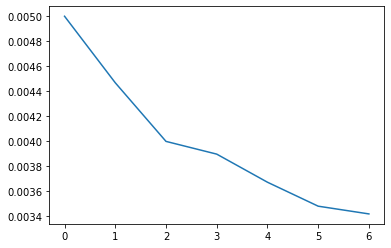

  0%|          | 0/1405 [00:00<?, ?it/s]

1600 :  0.0032457565924735882
1800 :  0.0033666714221589934
2000 :  0.0032297902458488193
2200 :  0.0030622082193513377
2400 :  0.002769479728913197
2600 :  0.002711446288256562
2800 :  0.002662568090458365
Tokens
              precision    recall  f1-score   support

           O       0.90      0.98      0.94    169578
         PER       0.67      0.53      0.59     11128
         ORG       0.55      0.31      0.40     10025
         LOC       0.51      0.30      0.38      8297
        MISC       0.49      0.10      0.17      4593

    accuracy                           0.87    203621
   macro avg       0.62      0.44      0.49    203621
weighted avg       0.85      0.87      0.85    203621

Tokens
              precision    recall  f1-score   support

           O       0.95      0.99      0.97     42759
         PER       0.89      0.83      0.86      3149
         ORG       0.70      0.49      0.57      2092
         LOC       0.69      0.73      0.71      2094
        MISC       

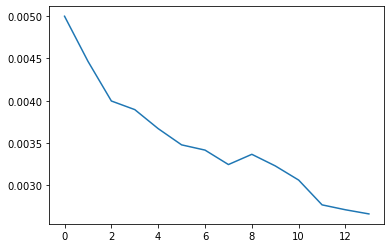

  0%|          | 0/1405 [00:00<?, ?it/s]

3000 :  0.0028422042692660843
3200 :  0.0023282704833084474
3400 :  0.00233708294146129
3600 :  0.002276877284679879
3800 :  0.0021336189428756633
4000 :  0.0020878216499077775
4200 :  0.0020459696991648154
Tokens
              precision    recall  f1-score   support

           O       0.94      0.98      0.96    169578
         PER       0.72      0.69      0.70     11128
         ORG       0.57      0.46      0.50     10025
         LOC       0.58      0.49      0.53      8297
        MISC       0.45      0.19      0.27      4593

    accuracy                           0.90    203621
   macro avg       0.65      0.56      0.59    203621
weighted avg       0.89      0.90      0.89    203621

Tokens
              precision    recall  f1-score   support

           O       0.98      0.99      0.98     42759
         PER       0.84      0.95      0.89      3149
         ORG       0.74      0.55      0.63      2092
         LOC       0.71      0.84      0.77      2094
        MISC       

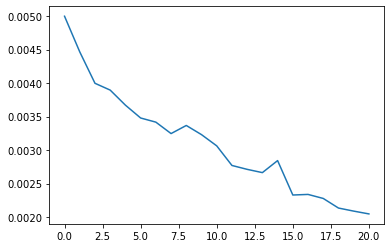

  0%|          | 0/1405 [00:00<?, ?it/s]

4400 :  0.0020533168695487927
4600 :  0.0018925193180723981
4800 :  0.001968703397468844
5000 :  0.0019381010800170997
5200 :  0.0018469821145421772
5400 :  0.0018418714949260137
5600 :  0.0018926355980408945
Tokens
              precision    recall  f1-score   support

           O       0.96      0.98      0.97    169578
         PER       0.74      0.77      0.75     11128
         ORG       0.58      0.52      0.55     10025
         LOC       0.60      0.56      0.58      8297
        MISC       0.52      0.27      0.35      4593

    accuracy                           0.91    203621
   macro avg       0.68      0.62      0.64    203621
weighted avg       0.91      0.91      0.91    203621

Tokens
              precision    recall  f1-score   support

           O       0.98      0.99      0.99     42759
         PER       0.81      0.96      0.88      3149
         ORG       0.81      0.51      0.62      2092
         LOC       0.77      0.84      0.80      2094
        MISC     

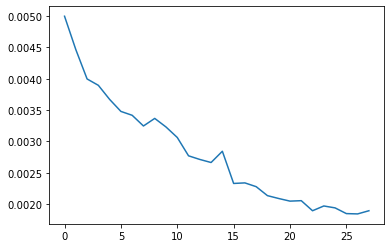

  0%|          | 0/1405 [00:00<?, ?it/s]

5800 :  0.001802656409935516
6000 :  0.0017975013725902544
6200 :  0.0016212676244759508
6400 :  0.001790635938621333
6600 :  0.001674560658427357
6800 :  0.0016570236683267246
7000 :  0.0017204030532434805
Tokens
              precision    recall  f1-score   support

           O       0.97      0.98      0.98    169578
         PER       0.77      0.79      0.78     11128
         ORG       0.61      0.56      0.59     10025
         LOC       0.63      0.61      0.62      8297
        MISC       0.53      0.32      0.40      4593

    accuracy                           0.92    203621
   macro avg       0.70      0.65      0.67    203621
weighted avg       0.92      0.92      0.92    203621

Tokens
              precision    recall  f1-score   support

           O       0.98      0.99      0.99     42759
         PER       0.87      0.95      0.91      3149
         ORG       0.76      0.63      0.69      2092
         LOC       0.77      0.85      0.81      2094
        MISC       

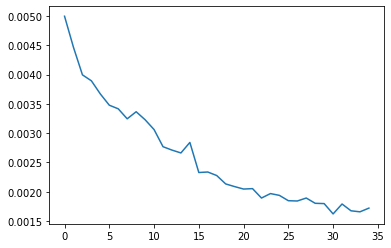

  0%|          | 0/1405 [00:00<?, ?it/s]

7200 :  0.0016548791845980542
7400 :  0.0014931147941264961
7600 :  0.0016702396080372018
7800 :  0.0016408582561202453
8000 :  0.0017895518242326566
8200 :  0.0017163320448108216
8400 :  0.0016119328939584738
Tokens
              precision    recall  f1-score   support

           O       0.97      0.98      0.98    169578
         PER       0.77      0.81      0.79     11128
         ORG       0.62      0.58      0.60     10025
         LOC       0.64      0.64      0.64      8297
        MISC       0.55      0.33      0.41      4593

    accuracy                           0.93    203621
   macro avg       0.71      0.67      0.68    203621
weighted avg       0.92      0.93      0.92    203621

Tokens
              precision    recall  f1-score   support

           O       0.99      0.99      0.99     42759
         PER       0.86      0.96      0.90      3149
         ORG       0.77      0.64      0.70      2092
         LOC       0.77      0.86      0.81      2094
        MISC    

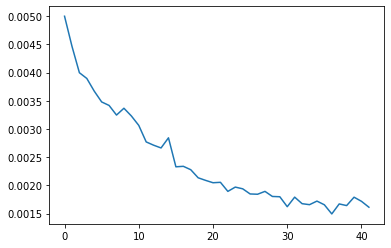

  0%|          | 0/1405 [00:00<?, ?it/s]

8600 :  0.001578924868620004
8800 :  0.0016435631876357952
9000 :  0.0016182364016437988
9200 :  0.0016305702711275607
9400 :  0.0015973725927814167
9600 :  0.0015444565327989062
9800 :  0.0014757099224145505
Tokens
              precision    recall  f1-score   support

           O       0.98      0.99      0.98    169578
         PER       0.79      0.82      0.80     11128
         ORG       0.63      0.59      0.61     10025
         LOC       0.66      0.66      0.66      8297
        MISC       0.58      0.38      0.46      4593

    accuracy                           0.93    203621
   macro avg       0.73      0.69      0.70    203621
weighted avg       0.93      0.93      0.93    203621

Tokens
              precision    recall  f1-score   support

           O       0.99      0.99      0.99     42759
         PER       0.87      0.95      0.91      3149
         ORG       0.82      0.57      0.67      2092
         LOC       0.77      0.88      0.82      2094
        MISC     

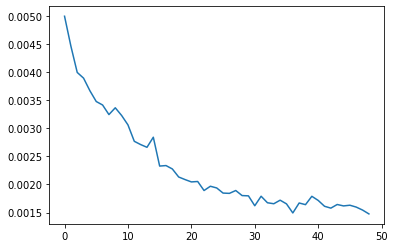

  0%|          | 0/1405 [00:00<?, ?it/s]

10000 :  0.0015018651881377144
10200 :  0.0015653756844615772
10400 :  0.0015612346278188146
10600 :  0.001587316736412793
10800 :  0.0015594906556496615
11000 :  0.001506298874047286
11200 :  0.0015772378733540748
Tokens
              precision    recall  f1-score   support

           O       0.98      0.99      0.98    169578
         PER       0.79      0.82      0.81     11128
         ORG       0.64      0.60      0.62     10025
         LOC       0.67      0.68      0.68      8297
        MISC       0.59      0.39      0.47      4593

    accuracy                           0.93    203621
   macro avg       0.73      0.70      0.71    203621
weighted avg       0.93      0.93      0.93    203621

Tokens
              precision    recall  f1-score   support

           O       0.98      0.99      0.99     42759
         PER       0.89      0.95      0.92      3149
         ORG       0.75      0.70      0.72      2092
         LOC       0.85      0.83      0.84      2094
        MIS

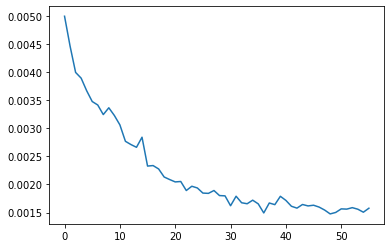

  0%|          | 0/1405 [00:00<?, ?it/s]

11400 :  0.002602497913057248
11600 :  0.0015147775917582768
11800 :  0.0015966330344175752
12000 :  0.0014887623977542697
12200 :  0.0013420702298293256
12400 :  0.0014473454595041483
12600 :  0.0013704029003874317
Tokens
              precision    recall  f1-score   support

           O       0.98      0.99      0.98    169578
         PER       0.80      0.84      0.82     11128
         ORG       0.65      0.60      0.62     10025
         LOC       0.69      0.70      0.69      8297
        MISC       0.61      0.41      0.49      4593

    accuracy                           0.93    203621
   macro avg       0.74      0.71      0.72    203621
weighted avg       0.93      0.93      0.93    203621

Tokens
              precision    recall  f1-score   support

           O       0.99      0.99      0.99     42759
         PER       0.91      0.93      0.92      3149
         ORG       0.75      0.71      0.73      2092
         LOC       0.85      0.85      0.85      2094
        MI

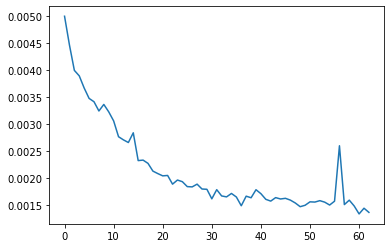

  0%|          | 0/1405 [00:00<?, ?it/s]

12800 :  0.0014703175662799308
13000 :  0.0014380316253815363
13200 :  0.0013509650409605787
13400 :  0.0014586823257428222
13600 :  0.001427436178846474
13800 :  0.0014433834645597248
14000 :  0.0013875319710317674
Tokens
              precision    recall  f1-score   support

           O       0.98      0.99      0.98    169578
         PER       0.81      0.84      0.82     11128
         ORG       0.66      0.62      0.64     10025
         LOC       0.70      0.70      0.70      8297
        MISC       0.60      0.41      0.49      4593

    accuracy                           0.94    203621
   macro avg       0.75      0.71      0.73    203621
weighted avg       0.93      0.94      0.93    203621

Tokens
              precision    recall  f1-score   support

           O       0.99      0.99      0.99     42759
         PER       0.87      0.95      0.91      3149
         ORG       0.77      0.69      0.73      2092
         LOC       0.83      0.85      0.84      2094
        MI

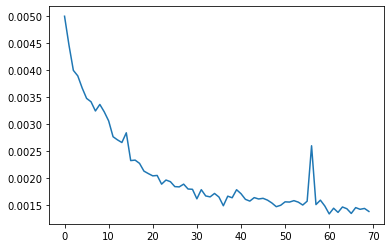

  0%|          | 0/1405 [00:00<?, ?it/s]

14200 :  0.0033741471154491915
14400 :  0.0014282810749561051
14600 :  0.0013474445100468521
14800 :  0.0014514097428914863
15000 :  0.0012619082038577995
15200 :  0.0014763945797112593
15400 :  0.0013264700331607861
Tokens
              precision    recall  f1-score   support

           O       0.98      0.99      0.98    169578
         PER       0.81      0.85      0.83     11128
         ORG       0.67      0.63      0.65     10025
         LOC       0.71      0.72      0.71      8297
        MISC       0.61      0.43      0.51      4593

    accuracy                           0.94    203621
   macro avg       0.76      0.72      0.74    203621
weighted avg       0.94      0.94      0.94    203621

Tokens
              precision    recall  f1-score   support

           O       0.99      0.99      0.99     42759
         PER       0.91      0.93      0.92      3149
         ORG       0.78      0.67      0.72      2092
         LOC       0.74      0.91      0.82      2094
        M

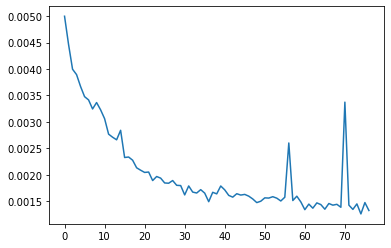

  0%|          | 0/1405 [00:00<?, ?it/s]

15600 :  0.0014806022392465227
15800 :  0.0014043010540934612
16000 :  0.001403650834699153
16200 :  0.0012988573533717165
16400 :  0.001415787145189751
16600 :  0.0012621340346423953
16800 :  0.0013404450193386986
Tokens
              precision    recall  f1-score   support

           O       0.98      0.99      0.98    169578
         PER       0.82      0.85      0.83     11128
         ORG       0.68      0.64      0.66     10025
         LOC       0.72      0.72      0.72      8297
        MISC       0.62      0.44      0.52      4593

    accuracy                           0.94    203621
   macro avg       0.76      0.73      0.74    203621
weighted avg       0.94      0.94      0.94    203621

Tokens
              precision    recall  f1-score   support

           O       0.99      0.99      0.99     42759
         PER       0.89      0.95      0.92      3149
         ORG       0.80      0.68      0.73      2092
         LOC       0.83      0.88      0.85      2094
        MIS

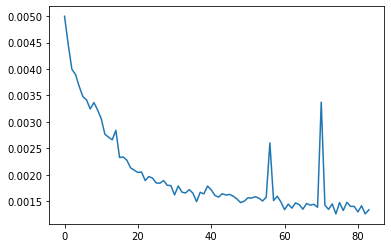

  0%|          | 0/1405 [00:00<?, ?it/s]

17000 :  0.0014428648964976754
17200 :  0.0013887222336446173
17400 :  0.0011810272142966072
17600 :  0.0013819946557603457
17800 :  0.001396387601537967
18000 :  0.0013123167162119233
18200 :  0.0013142760182394406
Tokens
              precision    recall  f1-score   support

           O       0.98      0.99      0.98    169578
         PER       0.82      0.85      0.84     11128
         ORG       0.68      0.65      0.66     10025
         LOC       0.72      0.73      0.72      8297
        MISC       0.63      0.45      0.53      4593

    accuracy                           0.94    203621
   macro avg       0.77      0.73      0.75    203621
weighted avg       0.94      0.94      0.94    203621

Tokens
              precision    recall  f1-score   support

           O       0.99      0.99      0.99     42759
         PER       0.89      0.95      0.92      3149
         ORG       0.82      0.66      0.73      2092
         LOC       0.81      0.89      0.85      2094
        MI

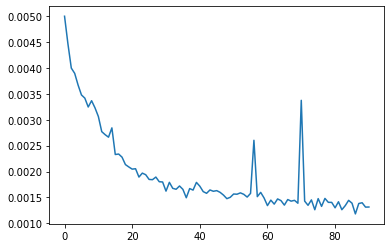

  0%|          | 0/1405 [00:00<?, ?it/s]

18400 :  0.001197868257413639
18600 :  0.0013828071272641977
18800 :  0.0013265411535454811
19000 :  0.0012981898664578538
19200 :  0.0013683584946465233
19400 :  0.001267837513993973
19600 :  0.0012787703593123768
Tokens
              precision    recall  f1-score   support

           O       0.98      0.99      0.98    169578
         PER       0.82      0.85      0.84     11128
         ORG       0.69      0.65      0.67     10025
         LOC       0.73      0.73      0.73      8297
        MISC       0.64      0.47      0.54      4593

    accuracy                           0.94    203621
   macro avg       0.77      0.74      0.75    203621
weighted avg       0.94      0.94      0.94    203621

Tokens
              precision    recall  f1-score   support

           O       0.98      1.00      0.99     42759
         PER       0.88      0.95      0.92      3149
         ORG       0.90      0.56      0.69      2092
         LOC       0.80      0.89      0.84      2094
        MIS

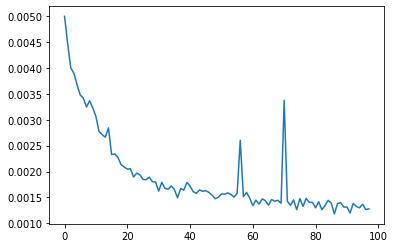

  0%|          | 0/1405 [00:00<?, ?it/s]

19800 :  0.0016270364737328803
20000 :  0.0013116345184659966
20200 :  0.0012041198078308467
20400 :  0.00130039451935456
20600 :  0.001267029111895092
20800 :  0.0012870445357220693
21000 :  0.0013501251538852491
Tokens
              precision    recall  f1-score   support

           O       0.98      0.99      0.99    169578
         PER       0.83      0.86      0.85     11128
         ORG       0.69      0.66      0.67     10025
         LOC       0.74      0.75      0.74      8297
        MISC       0.64      0.48      0.55      4593

    accuracy                           0.94    203621
   macro avg       0.78      0.75      0.76    203621
weighted avg       0.94      0.94      0.94    203621

Tokens
              precision    recall  f1-score   support

           O       0.99      1.00      0.99     42759
         PER       0.89      0.95      0.92      3149
         ORG       0.88      0.59      0.71      2092
         LOC       0.75      0.92      0.83      2094
        MISC

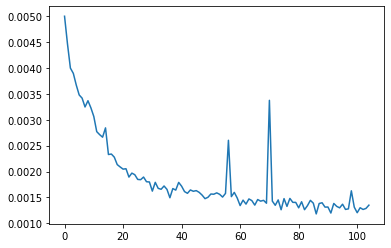

  0%|          | 0/1405 [00:00<?, ?it/s]

21200 :  0.0014225363854602788
21400 :  0.0012260798026456818
21600 :  0.0011419003052635975
21800 :  0.0012729179531829151
22000 :  0.0012185042252223447
22200 :  0.0013174683340401163
22400 :  0.0012484338249403202
Tokens
              precision    recall  f1-score   support

           O       0.98      0.99      0.99    169578
         PER       0.83      0.86      0.85     11128
         ORG       0.69      0.67      0.68     10025
         LOC       0.74      0.75      0.74      8297
        MISC       0.65      0.48      0.55      4593

    accuracy                           0.94    203621
   macro avg       0.78      0.75      0.76    203621
weighted avg       0.94      0.94      0.94    203621

Tokens
              precision    recall  f1-score   support

           O       0.99      0.99      0.99     42759
         PER       0.91      0.94      0.93      3149
         ORG       0.83      0.68      0.75      2092
         LOC       0.82      0.90      0.86      2094
        M

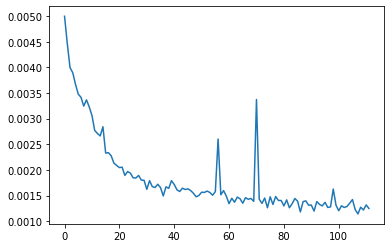

  0%|          | 0/1405 [00:00<?, ?it/s]

22600 :  0.002238152132865509
22800 :  0.001210825072433538
23000 :  0.001279396759546981
23200 :  0.0013499912266533793
23400 :  0.0011983496594455646
23600 :  0.0012735941569903535
23800 :  0.0011495029376470131
Tokens
              precision    recall  f1-score   support

           O       0.98      0.99      0.99    169578
         PER       0.83      0.86      0.85     11128
         ORG       0.71      0.67      0.68     10025
         LOC       0.74      0.75      0.75      8297
        MISC       0.66      0.49      0.56      4593

    accuracy                           0.95    203621
   macro avg       0.78      0.75      0.77    203621
weighted avg       0.94      0.95      0.94    203621

Tokens
              precision    recall  f1-score   support

           O       0.99      0.99      0.99     42759
         PER       0.84      0.97      0.90      3149
         ORG       0.83      0.67      0.74      2092
         LOC       0.82      0.89      0.85      2094
        MISC

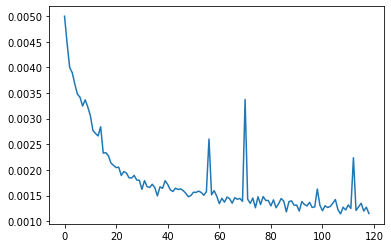

  0%|          | 0/1405 [00:00<?, ?it/s]

24000 :  0.0012268973089322596
24200 :  0.0011855681809479813
24400 :  0.0012662432325885804
24600 :  0.0012529447197626381
24800 :  0.001249120826453308
25000 :  0.0010946611340489562
25200 :  0.0012124336723980675
Tokens
              precision    recall  f1-score   support

           O       0.98      0.99      0.99    169578
         PER       0.84      0.87      0.86     11128
         ORG       0.70      0.68      0.69     10025
         LOC       0.75      0.75      0.75      8297
        MISC       0.66      0.51      0.57      4593

    accuracy                           0.95    203621
   macro avg       0.79      0.76      0.77    203621
weighted avg       0.94      0.95      0.95    203621

Tokens
              precision    recall  f1-score   support

           O       0.99      0.99      0.99     42759
         PER       0.90      0.95      0.92      3149
         ORG       0.85      0.68      0.75      2092
         LOC       0.83      0.89      0.86      2094
        MI

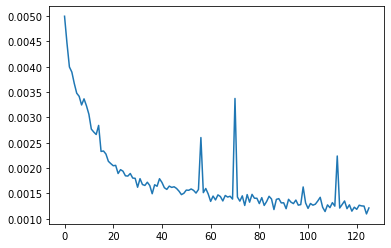

  0%|          | 0/1405 [00:00<?, ?it/s]

25400 :  0.001394182352065291
25600 :  0.0012468237165856296
25800 :  0.0011703766665030265
26000 :  0.001136835159784977
26200 :  0.0012591573331522826
26400 :  0.0011776487677089074
26600 :  0.0012197743423179657
Tokens
              precision    recall  f1-score   support

           O       0.98      0.99      0.99    169578
         PER       0.84      0.87      0.86     11128
         ORG       0.71      0.68      0.70     10025
         LOC       0.76      0.75      0.76      8297
        MISC       0.67      0.50      0.58      4593

    accuracy                           0.95    203621
   macro avg       0.79      0.76      0.77    203621
weighted avg       0.95      0.95      0.95    203621

Tokens
              precision    recall  f1-score   support

           O       0.99      1.00      0.99     42759
         PER       0.88      0.96      0.92      3149
         ORG       0.84      0.70      0.76      2092
         LOC       0.86      0.88      0.87      2094
        MIS

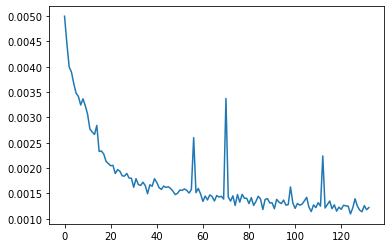

  0%|          | 0/1405 [00:00<?, ?it/s]

26800 :  0.0011593249848166375
27000 :  0.0011712163461620683
27200 :  0.0012084175185446697
27400 :  0.0012110469641549845
27600 :  0.0012278816971740903
27800 :  0.0013158247104852958
28000 :  0.0012672533166029271
Tokens
              precision    recall  f1-score   support

           O       0.98      0.99      0.99    169578
         PER       0.85      0.87      0.86     11128
         ORG       0.72      0.68      0.70     10025
         LOC       0.76      0.77      0.76      8297
        MISC       0.68      0.52      0.59      4593

    accuracy                           0.95    203621
   macro avg       0.80      0.77      0.78    203621
weighted avg       0.95      0.95      0.95    203621

Tokens
              precision    recall  f1-score   support

           O       0.99      1.00      0.99     42759
         PER       0.91      0.95      0.93      3149
         ORG       0.90      0.58      0.71      2092
         LOC       0.78      0.92      0.84      2094
        M

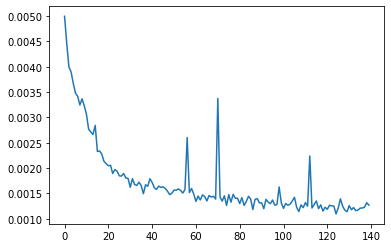

  0%|          | 0/1405 [00:00<?, ?it/s]

28200 :  0.0013170110871631572
28400 :  0.0012365308193980945
28600 :  0.001208687244822129
28800 :  0.0012336686156061024
29000 :  0.0012119251206149251
29200 :  0.0011930543170728628
29400 :  0.0011258412844629515
Tokens
              precision    recall  f1-score   support

           O       0.98      0.99      0.99    169578
         PER       0.85      0.87      0.86     11128
         ORG       0.71      0.69      0.70     10025
         LOC       0.77      0.77      0.77      8297
        MISC       0.68      0.52      0.59      4593

    accuracy                           0.95    203621
   macro avg       0.80      0.77      0.78    203621
weighted avg       0.95      0.95      0.95    203621

Tokens
              precision    recall  f1-score   support

           O       0.99      1.00      0.99     42759
         PER       0.90      0.96      0.93      3149
         ORG       0.82      0.72      0.77      2092
         LOC       0.84      0.89      0.86      2094
        MI

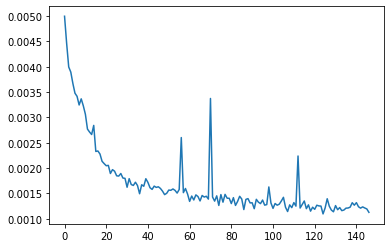

  0%|          | 0/1405 [00:00<?, ?it/s]

29600 :  0.0011528255847900247
29800 :  0.001158189538045521
30000 :  0.001225850640414828
30200 :  0.0011251055068338363
30400 :  0.0011029706576409723
30600 :  0.001132170363995527
30800 :  0.0011696083513699769
Tokens
              precision    recall  f1-score   support

           O       0.98      0.99      0.99    169578
         PER       0.86      0.88      0.87     11128
         ORG       0.72      0.70      0.71     10025
         LOC       0.77      0.77      0.77      8297
        MISC       0.68      0.52      0.59      4593

    accuracy                           0.95    203621
   macro avg       0.80      0.77      0.79    203621
weighted avg       0.95      0.95      0.95    203621

Tokens
              precision    recall  f1-score   support

           O       0.99      0.99      0.99     42759
         PER       0.89      0.96      0.92      3149
         ORG       0.86      0.70      0.77      2092
         LOC       0.81      0.91      0.86      2094
        MISC

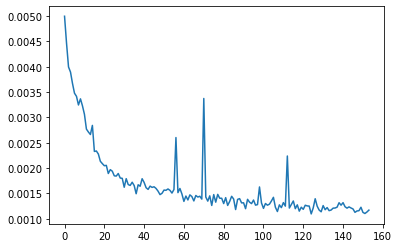

  0%|          | 0/1405 [00:00<?, ?it/s]

31000 :  0.0013865708985044362
31200 :  0.001165016179300827
31400 :  0.0011980950627298193
31600 :  0.001155919352298771
31800 :  0.0010672501699248232
32000 :  0.0011361227399921392
32200 :  0.0012101810475211798
Tokens
              precision    recall  f1-score   support

           O       0.98      0.99      0.99    169578
         PER       0.85      0.87      0.86     11128
         ORG       0.73      0.70      0.71     10025
         LOC       0.77      0.78      0.77      8297
        MISC       0.67      0.53      0.59      4593

    accuracy                           0.95    203621
   macro avg       0.80      0.77      0.79    203621
weighted avg       0.95      0.95      0.95    203621

Tokens
              precision    recall  f1-score   support

           O       0.99      0.99      0.99     42759
         PER       0.88      0.97      0.92      3149
         ORG       0.82      0.73      0.77      2092
         LOC       0.87      0.89      0.88      2094
        MIS

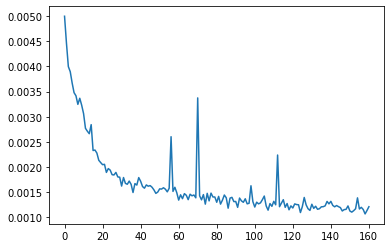

  0%|          | 0/1405 [00:00<?, ?it/s]

32400 :  0.0011513580297632183
32600 :  0.0011764346901642737
32800 :  0.0011255248160710234
33000 :  0.0011395703771006761
33200 :  0.001118543034016528
33400 :  0.0011466574164627152
33600 :  0.001132358072894791
Tokens
              precision    recall  f1-score   support

           O       0.98      0.99      0.99    169578
         PER       0.86      0.88      0.87     11128
         ORG       0.73      0.70      0.72     10025
         LOC       0.77      0.77      0.77      8297
        MISC       0.69      0.54      0.61      4593

    accuracy                           0.95    203621
   macro avg       0.81      0.78      0.79    203621
weighted avg       0.95      0.95      0.95    203621

Tokens
              precision    recall  f1-score   support

           O       0.99      0.99      0.99     42759
         PER       0.90      0.96      0.93      3149
         ORG       0.84      0.71      0.77      2092
         LOC       0.84      0.91      0.87      2094
        MIS

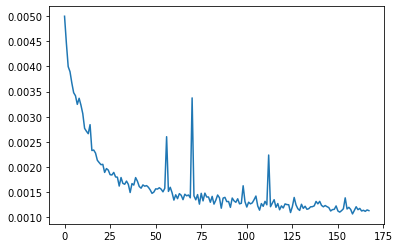

  0%|          | 0/1405 [00:00<?, ?it/s]

33800 :  0.0012538542046481903
34000 :  0.0012283916409292178
34200 :  0.001125767970342417
34400 :  0.001066710399967567
34600 :  0.0011698221943524675
34800 :  0.0010726993291955722
35000 :  0.0010762230266498183
Tokens
              precision    recall  f1-score   support

           O       0.98      0.99      0.99    169578
         PER       0.86      0.88      0.87     11128
         ORG       0.73      0.70      0.72     10025
         LOC       0.78      0.78      0.78      8297
        MISC       0.69      0.55      0.61      4593

    accuracy                           0.95    203621
   macro avg       0.81      0.78      0.79    203621
weighted avg       0.95      0.95      0.95    203621

Tokens
              precision    recall  f1-score   support

           O       0.99      0.99      0.99     42759
         PER       0.89      0.96      0.92      3149
         ORG       0.82      0.74      0.78      2092
         LOC       0.87      0.88      0.88      2094
        MIS

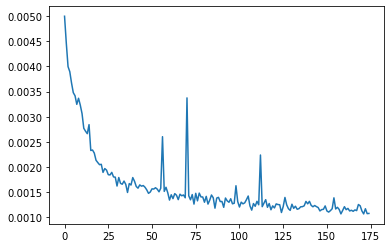

  0%|          | 0/1405 [00:00<?, ?it/s]

35200 :  0.0027730873633207056
35400 :  0.001045697420680328
35600 :  0.0012157404580452683
35800 :  0.0010899113885429893
36000 :  0.0010630666945509488
36200 :  0.0010312604319569132
36400 :  0.001105403544655524
Tokens
              precision    recall  f1-score   support

           O       0.98      0.99      0.99    169578
         PER       0.86      0.88      0.87     11128
         ORG       0.73      0.70      0.72     10025
         LOC       0.78      0.78      0.78      8297
        MISC       0.69      0.55      0.61      4593

    accuracy                           0.95    203621
   macro avg       0.81      0.78      0.79    203621
weighted avg       0.95      0.95      0.95    203621

Tokens
              precision    recall  f1-score   support

           O       0.99      1.00      0.99     42759
         PER       0.91      0.95      0.93      3149
         ORG       0.86      0.70      0.77      2092
         LOC       0.83      0.91      0.87      2094
        MIS

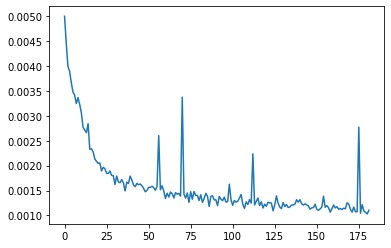

  0%|          | 0/1405 [00:00<?, ?it/s]

36600 :  0.001178458492683394
36800 :  0.0011466206600870932
37000 :  0.0010938533854585673
37200 :  0.0010949406545249772
37400 :  0.0011109114601515714
37600 :  0.001099175639710662
37800 :  0.001097829952313217
Tokens
              precision    recall  f1-score   support

           O       0.98      0.99      0.99    169578
         PER       0.86      0.88      0.87     11128
         ORG       0.73      0.70      0.71     10025
         LOC       0.78      0.79      0.78      8297
        MISC       0.70      0.54      0.61      4593

    accuracy                           0.95    203621
   macro avg       0.81      0.78      0.79    203621
weighted avg       0.95      0.95      0.95    203621

Tokens
              precision    recall  f1-score   support

           O       0.99      0.99      0.99     42759
         PER       0.89      0.97      0.93      3149
         ORG       0.85      0.72      0.78      2092
         LOC       0.84      0.90      0.87      2094
        MISC

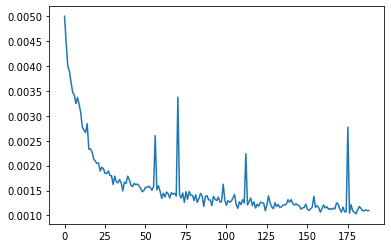

  0%|          | 0/1405 [00:00<?, ?it/s]

38000 :  0.0016424410016801672
38200 :  0.001113694607088297
38400 :  0.0011514812276910988
38600 :  0.0010535497469452391
38800 :  0.0010951929882973576
39000 :  0.001080587430982776
39200 :  0.001090097147901801
Tokens
              precision    recall  f1-score   support

           O       0.99      0.99      0.99    169578
         PER       0.86      0.88      0.87     11128
         ORG       0.74      0.71      0.73     10025
         LOC       0.78      0.79      0.79      8297
        MISC       0.71      0.55      0.62      4593

    accuracy                           0.95    203621
   macro avg       0.81      0.79      0.80    203621
weighted avg       0.95      0.95      0.95    203621

Tokens
              precision    recall  f1-score   support

           O       0.99      1.00      0.99     42759
         PER       0.90      0.96      0.93      3149
         ORG       0.81      0.77      0.79      2092
         LOC       0.88      0.88      0.88      2094
        MISC

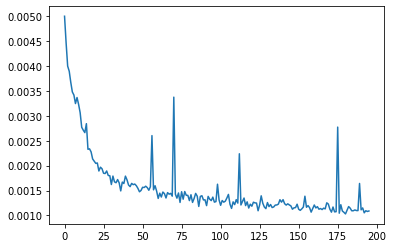

  0%|          | 0/1405 [00:00<?, ?it/s]

39400 :  0.0010513438384700162
39600 :  0.0011530682688865375
39800 :  0.001122084326232147
40000 :  0.001158870987718355
40200 :  0.0010898715258416338
40400 :  0.0010556712740236107
40600 :  0.001203939513461897
Tokens
              precision    recall  f1-score   support

           O       0.98      0.99      0.99    169578
         PER       0.86      0.88      0.87     11128
         ORG       0.74      0.71      0.72     10025
         LOC       0.78      0.79      0.78      8297
        MISC       0.69      0.54      0.61      4593

    accuracy                           0.95    203621
   macro avg       0.81      0.78      0.79    203621
weighted avg       0.95      0.95      0.95    203621

Tokens
              precision    recall  f1-score   support

           O       0.99      1.00      0.99     42759
         PER       0.90      0.96      0.93      3149
         ORG       0.82      0.77      0.79      2092
         LOC       0.89      0.88      0.89      2094
        MISC

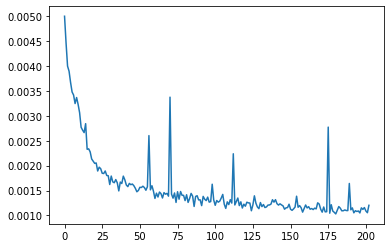

  0%|          | 0/1405 [00:00<?, ?it/s]

40800 :  0.0014728550137258706
41000 :  0.0010263597784532803
41200 :  0.001094706565270639
41400 :  0.0011255734569737288
41600 :  0.0010437414013562062
41800 :  0.0010095044701419807
42000 :  0.0010941150698080828
Tokens
              precision    recall  f1-score   support

           O       0.98      0.99      0.99    169578
         PER       0.86      0.89      0.87     11128
         ORG       0.74      0.71      0.72     10025
         LOC       0.79      0.79      0.79      8297
        MISC       0.70      0.56      0.62      4593

    accuracy                           0.95    203621
   macro avg       0.82      0.79      0.80    203621
weighted avg       0.95      0.95      0.95    203621

Tokens
              precision    recall  f1-score   support

           O       0.99      1.00      0.99     42759
         PER       0.88      0.97      0.92      3149
         ORG       0.87      0.70      0.77      2092
         LOC       0.85      0.91      0.88      2094
        MI

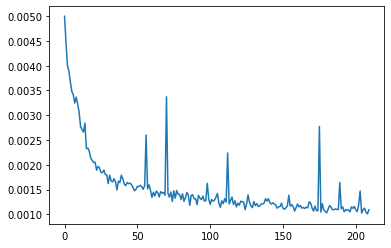

  0%|          | 0/1405 [00:00<?, ?it/s]

42200 :  0.0010486487221442887
42400 :  0.001064604574176706
42600 :  0.0010591554442653391
42800 :  0.0010906957342071018
43000 :  0.0011124369952355423
43200 :  0.0009959410369586392
43400 :  0.0010345817776871897
Tokens
              precision    recall  f1-score   support

           O       0.99      0.99      0.99    169578
         PER       0.86      0.89      0.87     11128
         ORG       0.75      0.72      0.73     10025
         LOC       0.79      0.80      0.79      8297
        MISC       0.71      0.57      0.63      4593

    accuracy                           0.95    203621
   macro avg       0.82      0.79      0.80    203621
weighted avg       0.95      0.95      0.95    203621

Tokens
              precision    recall  f1-score   support

           O       0.99      1.00      0.99     42759
         PER       0.90      0.96      0.93      3149
         ORG       0.85      0.72      0.78      2092
         LOC       0.85      0.90      0.88      2094
        MI

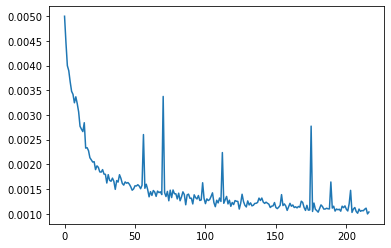

  0%|          | 0/1405 [00:00<?, ?it/s]

43600 :  0.00102839910082351
43800 :  0.0011805664027351955
44000 :  0.0011420443130553683
44200 :  0.0010579857777200715
44400 :  0.0010595287630390455
44600 :  0.0010625140192586614
44800 :  0.001037105674200342
Tokens
              precision    recall  f1-score   support

           O       0.99      0.99      0.99    169578
         PER       0.86      0.88      0.87     11128
         ORG       0.75      0.71      0.73     10025
         LOC       0.79      0.79      0.79      8297
        MISC       0.71      0.57      0.63      4593

    accuracy                           0.95    203621
   macro avg       0.82      0.79      0.80    203621
weighted avg       0.95      0.95      0.95    203621

Tokens
              precision    recall  f1-score   support

           O       0.99      0.99      0.99     42759
         PER       0.89      0.97      0.93      3149
         ORG       0.86      0.72      0.78      2092
         LOC       0.88      0.90      0.89      2094
        MISC

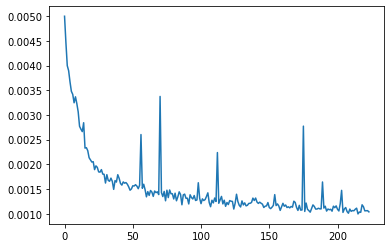

  0%|          | 0/1405 [00:00<?, ?it/s]

45000 :  0.0010918208330364463
45200 :  0.0010941154844081584
45400 :  0.001008393569905561
45600 :  0.001057387537606111
45800 :  0.0010838004319664593
46000 :  0.0011201504705698638
46200 :  0.0010469775073094498
Tokens
              precision    recall  f1-score   support

           O       0.99      0.99      0.99    169578
         PER       0.87      0.89      0.88     11128
         ORG       0.74      0.72      0.73     10025
         LOC       0.80      0.80      0.80      8297
        MISC       0.70      0.57      0.63      4593

    accuracy                           0.95    203621
   macro avg       0.82      0.79      0.80    203621
weighted avg       0.95      0.95      0.95    203621

Tokens
              precision    recall  f1-score   support

           O       0.99      0.99      0.99     42759
         PER       0.90      0.96      0.93      3149
         ORG       0.82      0.76      0.79      2092
         LOC       0.86      0.91      0.88      2094
        MIS

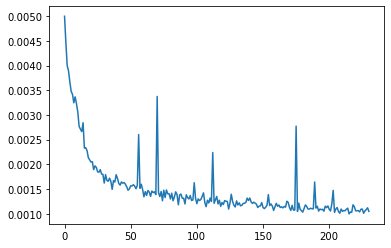

  0%|          | 0/1405 [00:00<?, ?it/s]

46400 :  0.0010879793988914782
46600 :  0.0009998795881941982
46800 :  0.0010329775551296539
47000 :  0.0010656845841915082
47200 :  0.0010492969056921312
47400 :  0.0010672571276407533
47600 :  0.0010494512632385432
Tokens
              precision    recall  f1-score   support

           O       0.99      0.99      0.99    169578
         PER       0.87      0.89      0.88     11128
         ORG       0.75      0.72      0.74     10025
         LOC       0.80      0.80      0.80      8297
        MISC       0.72      0.57      0.64      4593

    accuracy                           0.96    203621
   macro avg       0.83      0.79      0.81    203621
weighted avg       0.95      0.96      0.95    203621

Tokens
              precision    recall  f1-score   support

           O       0.99      1.00      0.99     42759
         PER       0.90      0.96      0.93      3149
         ORG       0.86      0.73      0.79      2092
         LOC       0.85      0.91      0.88      2094
        M

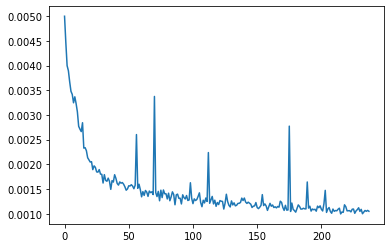

  0%|          | 0/1405 [00:00<?, ?it/s]

47800 :  0.001130232566133416
48000 :  0.001038388459947549
48200 :  0.0010919346753868993
48400 :  0.0010503035712575428
48600 :  0.0010535101317621222
48800 :  0.0009888485448633383
49000 :  0.0010755658850892928
Tokens
              precision    recall  f1-score   support

           O       0.99      0.99      0.99    169578
         PER       0.87      0.88      0.88     11128
         ORG       0.75      0.72      0.73     10025
         LOC       0.80      0.79      0.79      8297
        MISC       0.71      0.57      0.63      4593

    accuracy                           0.95    203621
   macro avg       0.82      0.79      0.80    203621
weighted avg       0.95      0.95      0.95    203621

Tokens
              precision    recall  f1-score   support

           O       0.99      1.00      0.99     42759
         PER       0.90      0.96      0.93      3149
         ORG       0.86      0.73      0.79      2092
         LOC       0.87      0.90      0.89      2094
        MIS

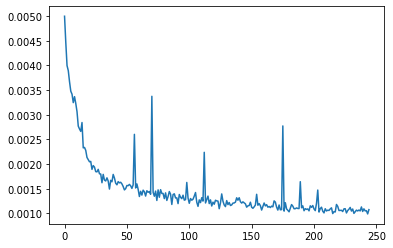

  0%|          | 0/1405 [00:00<?, ?it/s]

49200 :  0.0010718510739182753
49400 :  0.0010590132989825578
49600 :  0.0011407526998723696
49800 :  0.001071909902739864
50000 :  0.001014410436258921
50200 :  0.00104065304669716
50400 :  0.001010006795074885
Tokens
              precision    recall  f1-score   support

           O       0.99      0.99      0.99    169578
         PER       0.87      0.88      0.88     11128
         ORG       0.75      0.72      0.74     10025
         LOC       0.79      0.80      0.80      8297
        MISC       0.72      0.58      0.64      4593

    accuracy                           0.95    203621
   macro avg       0.82      0.80      0.81    203621
weighted avg       0.95      0.95      0.95    203621

Tokens
              precision    recall  f1-score   support

           O       0.99      1.00      0.99     42759
         PER       0.89      0.97      0.93      3149
         ORG       0.87      0.73      0.79      2092
         LOC       0.85      0.92      0.88      2094
        MISC  

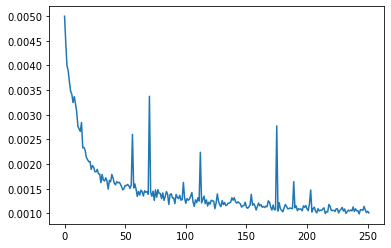

  0%|          | 0/1405 [00:00<?, ?it/s]

50600 :  0.0010559851808582274
50800 :  0.0010084876516513704
51000 :  0.001068616050441783
51200 :  0.0010279280174885152
51400 :  0.0010669066743450631
51600 :  0.0009964726819233487
51800 :  0.0010966860271666918
Tokens
              precision    recall  f1-score   support

           O       0.99      0.99      0.99    169578
         PER       0.87      0.89      0.88     11128
         ORG       0.75      0.73      0.74     10025
         LOC       0.79      0.80      0.80      8297
        MISC       0.72      0.58      0.64      4593

    accuracy                           0.96    203621
   macro avg       0.83      0.80      0.81    203621
weighted avg       0.95      0.96      0.95    203621

Tokens
              precision    recall  f1-score   support

           O       0.99      1.00      0.99     42759
         PER       0.91      0.96      0.94      3149
         ORG       0.85      0.78      0.81      2092
         LOC       0.89      0.90      0.89      2094
        MI

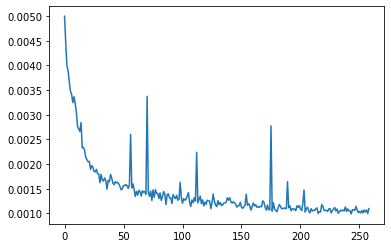

  0%|          | 0/1405 [00:00<?, ?it/s]

52000 :  0.001182317160597271
52200 :  0.0009878744048648187
52400 :  0.0010682771784242063
52600 :  0.0010301276489767675
52800 :  0.0010326960933577302
53000 :  0.0010018247963144947
53200 :  0.0010418553586820567
Tokens
              precision    recall  f1-score   support

           O       0.99      0.99      0.99    169578
         PER       0.87      0.89      0.88     11128
         ORG       0.75      0.73      0.74     10025
         LOC       0.81      0.81      0.81      8297
        MISC       0.73      0.59      0.65      4593

    accuracy                           0.96    203621
   macro avg       0.83      0.80      0.81    203621
weighted avg       0.96      0.96      0.96    203621

Tokens
              precision    recall  f1-score   support

           O       0.99      0.99      0.99     42759
         PER       0.89      0.97      0.93      3149
         ORG       0.87      0.73      0.79      2092
         LOC       0.86      0.92      0.89      2094
        MI

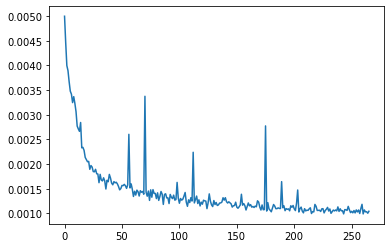

  0%|          | 0/1405 [00:00<?, ?it/s]

53400 :  0.0010370338879698623
53600 :  0.0010554220581679933
53800 :  0.0010850722810541958
54000 :  0.0010331000122796024
54200 :  0.0010184391721799926
54400 :  0.0009552681762456932
54600 :  0.000942023696149983
Tokens
              precision    recall  f1-score   support

           O       0.99      0.99      0.99    169578
         PER       0.87      0.89      0.88     11128
         ORG       0.75      0.73      0.74     10025
         LOC       0.80      0.80      0.80      8297
        MISC       0.72      0.58      0.65      4593

    accuracy                           0.96    203621
   macro avg       0.83      0.80      0.81    203621
weighted avg       0.96      0.96      0.96    203621

Tokens
              precision    recall  f1-score   support

           O       0.99      1.00      0.99     42759
         PER       0.89      0.97      0.93      3149
         ORG       0.86      0.76      0.81      2092
         LOC       0.89      0.90      0.90      2094
        MI

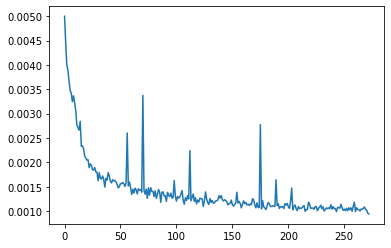

  0%|          | 0/1405 [00:00<?, ?it/s]

54800 :  0.0010094435521287033
55000 :  0.0009612800180152142
55200 :  0.0009777970493875284
55400 :  0.0009286744791165368
55600 :  0.0009986736048697286
55800 :  0.0009949504143189644
56000 :  0.0009908742906561078
56200 :  0.0010822397508668468
Tokens
              precision    recall  f1-score   support

           O       0.99      0.99      0.99    169578
         PER       0.87      0.89      0.88     11128
         ORG       0.76      0.73      0.75     10025
         LOC       0.80      0.81      0.80      8297
        MISC       0.74      0.59      0.66      4593

    accuracy                           0.96    203621
   macro avg       0.83      0.80      0.82    203621
weighted avg       0.96      0.96      0.96    203621

Tokens
              precision    recall  f1-score   support

           O       0.99      1.00      0.99     42759
         PER       0.90      0.96      0.93      3149
         ORG       0.88      0.72      0.79      2092
         LOC       0.86      0.9

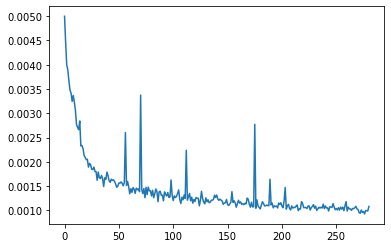

  0%|          | 0/1405 [00:00<?, ?it/s]

56400 :  0.0009767404544482737
56600 :  0.0010629863682505077
56800 :  0.001000620504242407
57000 :  0.0010091015051776502
57200 :  0.0010770265463157637
57400 :  0.0011191306900002825
57600 :  0.0010031189306566157
Tokens
              precision    recall  f1-score   support

           O       0.99      0.99      0.99    169578
         PER       0.87      0.89      0.88     11128
         ORG       0.75      0.73      0.74     10025
         LOC       0.80      0.81      0.81      8297
        MISC       0.73      0.59      0.65      4593

    accuracy                           0.96    203621
   macro avg       0.83      0.80      0.81    203621
weighted avg       0.95      0.96      0.96    203621

Tokens
              precision    recall  f1-score   support

           O       0.99      1.00      0.99     42759
         PER       0.92      0.96      0.94      3149
         ORG       0.83      0.80      0.81      2092
         LOC       0.89      0.90      0.90      2094
        MI

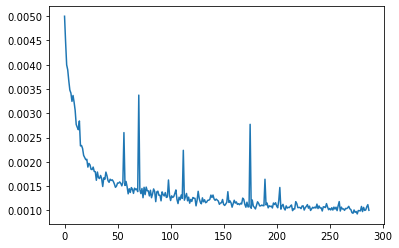

  0%|          | 0/1405 [00:00<?, ?it/s]

57800 :  0.0013093367305861388
58000 :  0.000979051068553447
58200 :  0.0009106336220608091
58400 :  0.0010572128274689645
58600 :  0.0010127042283716485
58800 :  0.0010169281504247459
59000 :  0.0009776087468423911
Tokens
              precision    recall  f1-score   support

           O       0.99      0.99      0.99    169578
         PER       0.87      0.89      0.88     11128
         ORG       0.76      0.73      0.75     10025
         LOC       0.81      0.81      0.81      8297
        MISC       0.74      0.59      0.66      4593

    accuracy                           0.96    203621
   macro avg       0.83      0.80      0.82    203621
weighted avg       0.96      0.96      0.96    203621

Tokens
              precision    recall  f1-score   support

           O       0.99      1.00      0.99     42759
         PER       0.91      0.97      0.94      3149
         ORG       0.81      0.81      0.81      2092
         LOC       0.90      0.89      0.89      2094
        MI

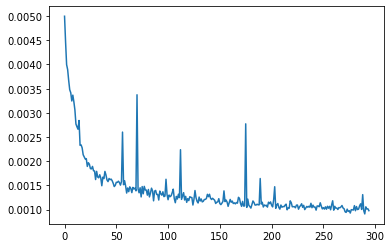

  0%|          | 0/1405 [00:00<?, ?it/s]

59200 :  0.0010089376042762633
59400 :  0.0010366990421533892
59600 :  0.001032060963790719
59800 :  0.0010077162365533716
60000 :  0.0010426890886884028
60200 :  0.0009392830022634436
60400 :  0.0010289256710611864
Tokens
              precision    recall  f1-score   support

           O       0.99      0.99      0.99    169578
         PER       0.88      0.89      0.88     11128
         ORG       0.75      0.73      0.74     10025
         LOC       0.81      0.81      0.81      8297
        MISC       0.73      0.60      0.66      4593

    accuracy                           0.96    203621
   macro avg       0.83      0.81      0.82    203621
weighted avg       0.96      0.96      0.96    203621

Tokens
              precision    recall  f1-score   support

           O       0.99      1.00      0.99     42759
         PER       0.91      0.96      0.94      3149
         ORG       0.85      0.77      0.81      2092
         LOC       0.89      0.90      0.90      2094
        MI

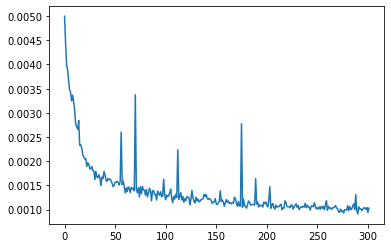

  0%|          | 0/1405 [00:00<?, ?it/s]

60600 :  0.001036769098106708
60800 :  0.001034740441191729
61000 :  0.0010116686083482195
61200 :  0.0009343339858524107
61400 :  0.0009623412821607357
61600 :  0.0009585024375627292
61800 :  0.00095225217568271
Tokens
              precision    recall  f1-score   support

           O       0.99      0.99      0.99    169578
         PER       0.87      0.89      0.88     11128
         ORG       0.76      0.74      0.75     10025
         LOC       0.81      0.81      0.81      8297
        MISC       0.73      0.60      0.66      4593

    accuracy                           0.96    203621
   macro avg       0.83      0.81      0.82    203621
weighted avg       0.96      0.96      0.96    203621

Tokens
              precision    recall  f1-score   support

           O       0.99      1.00      0.99     42759
         PER       0.91      0.96      0.94      3149
         ORG       0.84      0.80      0.82      2092
         LOC       0.90      0.90      0.90      2094
        MISC 

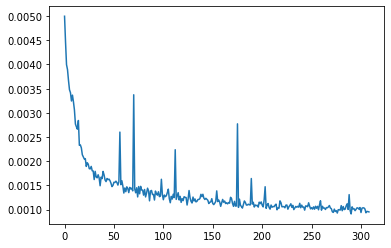

  0%|          | 0/1405 [00:00<?, ?it/s]

62000 :  0.0010423748747368546
62200 :  0.000972143089841054
62400 :  0.0009508039511356009
62600 :  0.0009922032399156272
62800 :  0.0009822984206132646
63000 :  0.000967808800880339
63200 :  0.0009468014449216462
Tokens
              precision    recall  f1-score   support

           O       0.99      0.99      0.99    169578
         PER       0.88      0.90      0.89     11128
         ORG       0.76      0.74      0.75     10025
         LOC       0.81      0.81      0.81      8297
        MISC       0.73      0.60      0.66      4593

    accuracy                           0.96    203621
   macro avg       0.83      0.81      0.82    203621
weighted avg       0.96      0.96      0.96    203621

Tokens
              precision    recall  f1-score   support

           O       0.99      1.00      0.99     42759
         PER       0.91      0.96      0.94      3149
         ORG       0.85      0.77      0.81      2092
         LOC       0.86      0.92      0.89      2094
        MIS

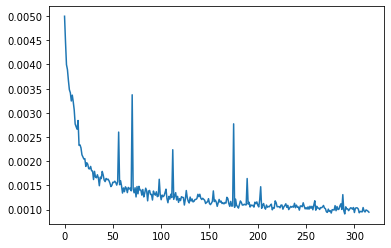

  0%|          | 0/1405 [00:00<?, ?it/s]

63400 :  0.001058133049090964
63600 :  0.000976329718015694
63800 :  0.0009210603931163488
64000 :  0.0010709282059959073
64200 :  0.0009258882298877613
64400 :  0.0010149722623021334
64600 :  0.00096502336812211
Tokens
              precision    recall  f1-score   support

           O       0.99      0.99      0.99    169578
         PER       0.88      0.90      0.89     11128
         ORG       0.76      0.74      0.75     10025
         LOC       0.81      0.81      0.81      8297
        MISC       0.73      0.61      0.66      4593

    accuracy                           0.96    203621
   macro avg       0.83      0.81      0.82    203621
weighted avg       0.96      0.96      0.96    203621

Tokens
              precision    recall  f1-score   support

           O       0.99      1.00      0.99     42759
         PER       0.92      0.96      0.94      3149
         ORG       0.85      0.78      0.81      2092
         LOC       0.84      0.93      0.88      2094
        MISC 

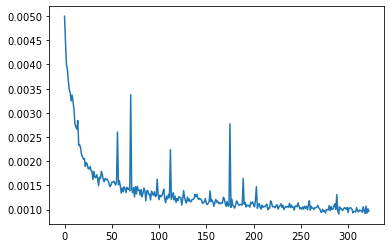

  0%|          | 0/1405 [00:00<?, ?it/s]

64800 :  0.0009345075455149914
65000 :  0.000934680658277626
65200 :  0.0009694861695769449
65400 :  0.0010581845289583686
65600 :  0.0010184759152207575
65800 :  0.0009412225714963093
66000 :  0.0009872128101980594
Tokens
              precision    recall  f1-score   support

           O       0.99      0.99      0.99    169578
         PER       0.88      0.89      0.89     11128
         ORG       0.76      0.74      0.75     10025
         LOC       0.81      0.81      0.81      8297
        MISC       0.73      0.61      0.67      4593

    accuracy                           0.96    203621
   macro avg       0.83      0.81      0.82    203621
weighted avg       0.96      0.96      0.96    203621

Tokens
              precision    recall  f1-score   support

           O       0.99      1.00      0.99     42759
         PER       0.91      0.96      0.94      3149
         ORG       0.83      0.79      0.81      2092
         LOC       0.89      0.92      0.90      2094
        MI

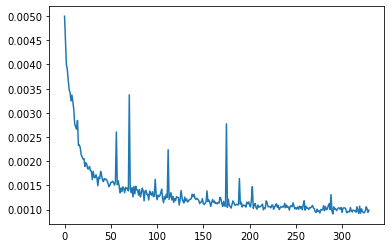

  0%|          | 0/1405 [00:00<?, ?it/s]

66200 :  0.0009562223249052388
66400 :  0.0009922251606478904
66600 :  0.0009399739564075911
66800 :  0.0010084416319511404
67000 :  0.0009490575963698888
67200 :  0.0010002906219263295
67400 :  0.0009879704655171443
Tokens
              precision    recall  f1-score   support

           O       0.99      0.99      0.99    169578
         PER       0.87      0.89      0.88     11128
         ORG       0.76      0.74      0.75     10025
         LOC       0.81      0.81      0.81      8297
        MISC       0.75      0.60      0.66      4593

    accuracy                           0.96    203621
   macro avg       0.83      0.81      0.82    203621
weighted avg       0.96      0.96      0.96    203621

Tokens
              precision    recall  f1-score   support

           O       0.99      1.00      0.99     42759
         PER       0.90      0.97      0.93      3149
         ORG       0.87      0.76      0.81      2092
         LOC       0.88      0.91      0.90      2094
        M

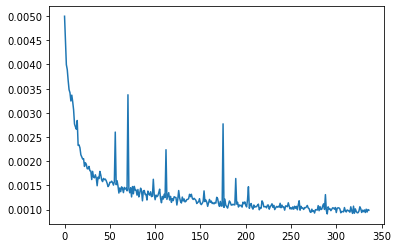

  0%|          | 0/1405 [00:00<?, ?it/s]

67600 :  0.001018600294930289
67800 :  0.0009759924826104732
68000 :  0.000998492455226821
68200 :  0.0009955284217451788
68400 :  0.0009299067842742976
68600 :  0.0009634295670582948
68800 :  0.00105178039924134
Tokens
              precision    recall  f1-score   support

           O       0.99      0.99      0.99    169578
         PER       0.88      0.90      0.89     11128
         ORG       0.76      0.74      0.75     10025
         LOC       0.81      0.81      0.81      8297
        MISC       0.74      0.61      0.67      4593

    accuracy                           0.96    203621
   macro avg       0.83      0.81      0.82    203621
weighted avg       0.96      0.96      0.96    203621

Tokens
              precision    recall  f1-score   support

           O       0.99      1.00      0.99     42759
         PER       0.93      0.95      0.94      3149
         ORG       0.85      0.79      0.82      2092
         LOC       0.87      0.92      0.89      2094
        MISC 

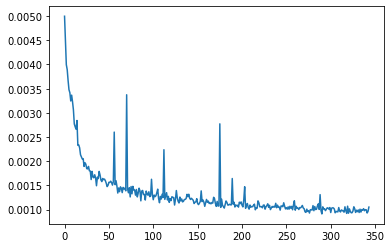

  0%|          | 0/1405 [00:00<?, ?it/s]

69000 :  0.0009255429898568607
69200 :  0.0009865088162639944
69400 :  0.0010067140170169088
69600 :  0.0010341115402392178
69800 :  0.0008661824836562466
70000 :  0.0009669769483302038
70200 :  0.0009965902469544305
Tokens
              precision    recall  f1-score   support

           O       0.99      0.99      0.99    169578
         PER       0.88      0.90      0.89     11128
         ORG       0.77      0.74      0.76     10025
         LOC       0.82      0.82      0.82      8297
        MISC       0.74      0.61      0.67      4593

    accuracy                           0.96    203621
   macro avg       0.84      0.81      0.82    203621
weighted avg       0.96      0.96      0.96    203621

Tokens
              precision    recall  f1-score   support

           O       0.99      1.00      0.99     42759
         PER       0.91      0.96      0.93      3149
         ORG       0.83      0.82      0.82      2092
         LOC       0.91      0.90      0.90      2094
        M

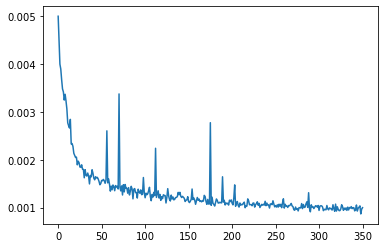

  0%|          | 0/1405 [00:00<?, ?it/s]

70400 :  0.0011540659701482282
70600 :  0.000908443796752927
70800 :  0.0009752450884661535
71000 :  0.000918945490798585
71200 :  0.0010095052675441077
71400 :  0.0009523417578267305
71600 :  0.0009021854658606018
Tokens
              precision    recall  f1-score   support

           O       0.99      0.99      0.99    169578
         PER       0.88      0.90      0.89     11128
         ORG       0.77      0.75      0.76     10025
         LOC       0.82      0.82      0.82      8297
        MISC       0.74      0.62      0.67      4593

    accuracy                           0.96    203621
   macro avg       0.84      0.81      0.82    203621
weighted avg       0.96      0.96      0.96    203621

Tokens
              precision    recall  f1-score   support

           O       0.99      1.00      0.99     42759
         PER       0.91      0.96      0.94      3149
         ORG       0.86      0.77      0.81      2092
         LOC       0.86      0.92      0.89      2094
        MIS

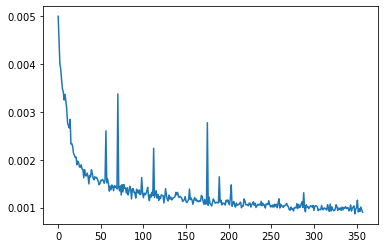

  0%|          | 0/1405 [00:00<?, ?it/s]

71800 :  0.0009751689516041989
72000 :  0.0009089212237410991
72200 :  0.000996296301182248
72400 :  0.001019805938375346
72600 :  0.0009859543448878078
72800 :  0.0008993120583941944
73000 :  0.0008559295535885657
Tokens
              precision    recall  f1-score   support

           O       0.99      0.99      0.99    169578
         PER       0.88      0.90      0.89     11128
         ORG       0.77      0.75      0.76     10025
         LOC       0.82      0.82      0.82      8297
        MISC       0.74      0.60      0.67      4593

    accuracy                           0.96    203621
   macro avg       0.84      0.81      0.82    203621
weighted avg       0.96      0.96      0.96    203621

Tokens
              precision    recall  f1-score   support

           O       0.99      0.99      0.99     42759
         PER       0.90      0.97      0.93      3149
         ORG       0.86      0.77      0.82      2092
         LOC       0.89      0.91      0.90      2094
        MIS

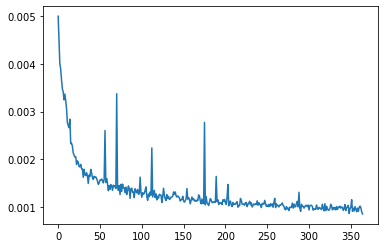

  0%|          | 0/1405 [00:00<?, ?it/s]

73200 :  0.0010781816190343315
73400 :  0.0009878637694163126
73600 :  0.0009294113298158289
73800 :  0.0008636033222608014
74000 :  0.0009471411812976575
74200 :  0.000981824098619776
74400 :  0.0009304599416816722
Tokens
              precision    recall  f1-score   support

           O       0.99      0.99      0.99    169578
         PER       0.88      0.90      0.89     11128
         ORG       0.77      0.75      0.76     10025
         LOC       0.82      0.82      0.82      8297
        MISC       0.74      0.62      0.68      4593

    accuracy                           0.96    203621
   macro avg       0.84      0.82      0.83    203621
weighted avg       0.96      0.96      0.96    203621

Tokens
              precision    recall  f1-score   support

           O       0.99      1.00      0.99     42759
         PER       0.91      0.96      0.94      3149
         ORG       0.85      0.78      0.81      2092
         LOC       0.87      0.92      0.89      2094
        MI

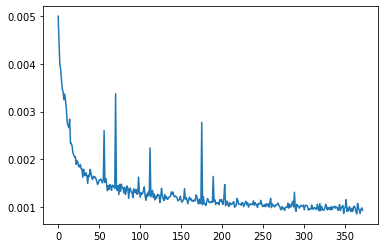

  0%|          | 0/1405 [00:00<?, ?it/s]

74600 :  0.001794032968082094
74800 :  0.0009158092203652831
75000 :  0.0009694879701225502
75200 :  0.0009556947171872882
75400 :  0.000961973414574672
75600 :  0.0009807234778656802
75800 :  0.0008641641385214185
Tokens
              precision    recall  f1-score   support

           O       0.99      0.99      0.99    169578
         PER       0.88      0.90      0.89     11128
         ORG       0.77      0.75      0.76     10025
         LOC       0.82      0.82      0.82      8297
        MISC       0.74      0.62      0.67      4593

    accuracy                           0.96    203621
   macro avg       0.84      0.82      0.83    203621
weighted avg       0.96      0.96      0.96    203621

Tokens
              precision    recall  f1-score   support

           O       0.99      1.00      0.99     42759
         PER       0.92      0.95      0.94      3149
         ORG       0.84      0.79      0.82      2092
         LOC       0.87      0.92      0.90      2094
        MIS

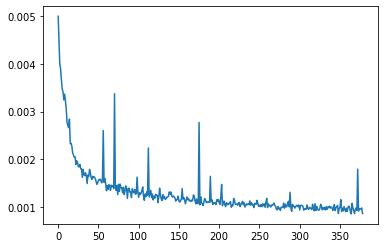

  0%|          | 0/1405 [00:00<?, ?it/s]

76000 :  0.0010909778279713889
76200 :  0.0008592013767854845
76400 :  0.0008783752561516339
76600 :  0.000983623911855178
76800 :  0.0009783265247107044
77000 :  0.0010230796174428506
77200 :  0.0010247872461392404
Tokens
              precision    recall  f1-score   support

           O       0.99      0.99      0.99    169578
         PER       0.88      0.90      0.89     11128
         ORG       0.77      0.75      0.76     10025
         LOC       0.82      0.82      0.82      8297
        MISC       0.75      0.61      0.67      4593

    accuracy                           0.96    203621
   macro avg       0.84      0.82      0.83    203621
weighted avg       0.96      0.96      0.96    203621

Tokens
              precision    recall  f1-score   support

           O       0.99      1.00      0.99     42759
         PER       0.91      0.96      0.94      3149
         ORG       0.86      0.78      0.82      2092
         LOC       0.88      0.92      0.90      2094
        MI

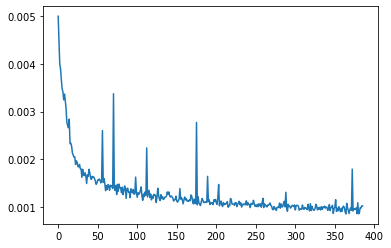

  0%|          | 0/1405 [00:00<?, ?it/s]

77400 :  0.0009452408576566094
77600 :  0.0009870861709516154
77800 :  0.000886277715420439
78000 :  0.0009604903003596402
78200 :  0.0009638626298043092
78400 :  0.0009165183854207342
78600 :  0.0008836225115665346
Tokens
              precision    recall  f1-score   support

           O       0.99      0.99      0.99    169578
         PER       0.89      0.91      0.90     11128
         ORG       0.77      0.75      0.76     10025
         LOC       0.82      0.82      0.82      8297
        MISC       0.75      0.62      0.68      4593

    accuracy                           0.96    203621
   macro avg       0.84      0.82      0.83    203621
weighted avg       0.96      0.96      0.96    203621

Tokens
              precision    recall  f1-score   support

           O       0.99      1.00      0.99     42759
         PER       0.91      0.96      0.94      3149
         ORG       0.89      0.76      0.82      2092
         LOC       0.89      0.92      0.91      2094
        MI

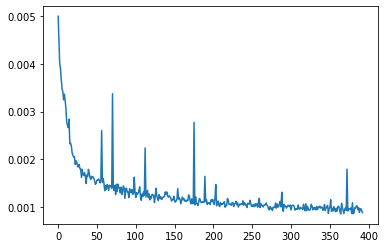

  0%|          | 0/1405 [00:00<?, ?it/s]

78800 :  0.0011807450722026976
79000 :  0.0009495718258802194
79200 :  0.000967585909428944
79400 :  0.0009125488149348902
79600 :  0.000916369552929202
79800 :  0.0008907225276855714
80000 :  0.0010016844238640013
Tokens
              precision    recall  f1-score   support

           O       0.99      0.99      0.99    169578
         PER       0.88      0.90      0.89     11128
         ORG       0.77      0.75      0.76     10025
         LOC       0.83      0.82      0.83      8297
        MISC       0.75      0.62      0.68      4593

    accuracy                           0.96    203621
   macro avg       0.84      0.82      0.83    203621
weighted avg       0.96      0.96      0.96    203621

Tokens
              precision    recall  f1-score   support

           O       0.99      1.00      0.99     42759
         PER       0.90      0.97      0.93      3149
         ORG       0.88      0.75      0.81      2092
         LOC       0.87      0.93      0.90      2094
        MIS

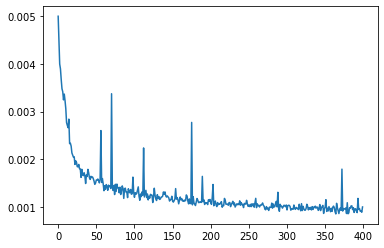

  0%|          | 0/1405 [00:00<?, ?it/s]

80200 :  0.0010130691708990218
80400 :  0.001008315907023145
80600 :  0.000887786388708771
80800 :  0.0008823698308594982
81000 :  0.0009756643192913342
81200 :  0.000997004763565108
81400 :  0.0009030722849324908
Tokens
              precision    recall  f1-score   support

           O       0.99      0.99      0.99    169578
         PER       0.88      0.90      0.89     11128
         ORG       0.78      0.76      0.77     10025
         LOC       0.82      0.82      0.82      8297
        MISC       0.75      0.62      0.68      4593

    accuracy                           0.96    203621
   macro avg       0.84      0.82      0.83    203621
weighted avg       0.96      0.96      0.96    203621

Tokens
              precision    recall  f1-score   support

           O       0.99      1.00      0.99     42759
         PER       0.93      0.95      0.94      3149
         ORG       0.84      0.81      0.82      2092
         LOC       0.89      0.91      0.90      2094
        MISC

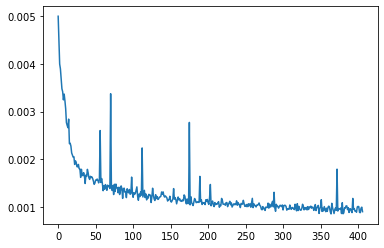

  0%|          | 0/1405 [00:00<?, ?it/s]

81600 :  0.0008733477495144931
81800 :  0.000987464674901635
82000 :  0.0009672542185183682
82200 :  0.0009549973210009674
82400 :  0.0008796683078897406
82600 :  0.0008751815454317188
82800 :  0.0008437298593344497
Tokens
              precision    recall  f1-score   support

           O       0.99      0.99      0.99    169578
         PER       0.88      0.90      0.89     11128
         ORG       0.77      0.76      0.77     10025
         LOC       0.83      0.83      0.83      8297
        MISC       0.75      0.63      0.68      4593

    accuracy                           0.96    203621
   macro avg       0.85      0.82      0.83    203621
weighted avg       0.96      0.96      0.96    203621

Tokens
              precision    recall  f1-score   support

           O       0.99      1.00      0.99     42759
         PER       0.91      0.96      0.94      3149
         ORG       0.86      0.80      0.83      2092
         LOC       0.91      0.91      0.91      2094
        MI

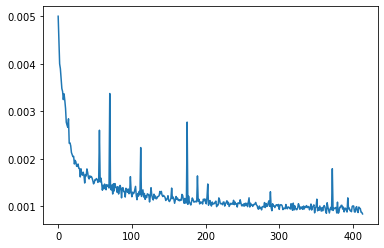

  0%|          | 0/1405 [00:00<?, ?it/s]

83000 :  0.0010680977424689854
83200 :  0.0009823414919569774
83400 :  0.000906874357042304
83600 :  0.0008855547235909704
83800 :  0.0008780713566505589
84000 :  0.000896996308533323
84200 :  0.0009490450723683044
Tokens
              precision    recall  f1-score   support

           O       0.99      0.99      0.99    169578
         PER       0.88      0.90      0.89     11128
         ORG       0.78      0.76      0.77     10025
         LOC       0.83      0.82      0.82      8297
        MISC       0.76      0.63      0.69      4593

    accuracy                           0.96    203621
   macro avg       0.85      0.82      0.83    203621
weighted avg       0.96      0.96      0.96    203621

Tokens
              precision    recall  f1-score   support

           O       0.99      1.00      0.99     42759
         PER       0.91      0.96      0.93      3149
         ORG       0.85      0.80      0.83      2092
         LOC       0.88      0.92      0.90      2094
        MIS

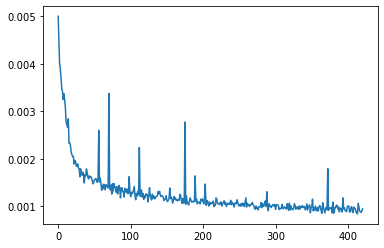

  0%|          | 0/1405 [00:00<?, ?it/s]

84400 :  0.0009603711757513113
84600 :  0.0008609373910402285
84800 :  0.0009899630058464786
85000 :  0.0009006868016534216
85200 :  0.0008859018606637615
85400 :  0.0009683474238528251
85600 :  0.0009029470138905212
Tokens
              precision    recall  f1-score   support

           O       0.99      0.99      0.99    169578
         PER       0.89      0.90      0.89     11128
         ORG       0.78      0.76      0.77     10025
         LOC       0.82      0.82      0.82      8297
        MISC       0.75      0.63      0.69      4593

    accuracy                           0.96    203621
   macro avg       0.85      0.82      0.83    203621
weighted avg       0.96      0.96      0.96    203621

Tokens
              precision    recall  f1-score   support

           O       0.99      1.00      0.99     42759
         PER       0.92      0.96      0.94      3149
         ORG       0.86      0.79      0.82      2092
         LOC       0.88      0.92      0.90      2094
        M

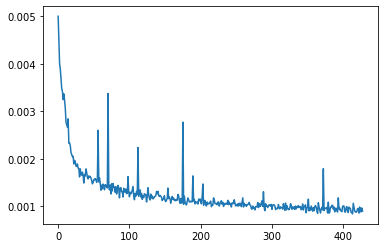

  0%|          | 0/1405 [00:00<?, ?it/s]

85800 :  0.0011063626009905076
86000 :  0.0009212059615492997
86200 :  0.0009097447560656997
86400 :  0.0009757718923301763
86600 :  0.0009503766103255997
86800 :  0.0010013487078383329
87000 :  0.0008233056690428786
Tokens
              precision    recall  f1-score   support

           O       0.99      0.99      0.99    169578
         PER       0.89      0.90      0.89     11128
         ORG       0.78      0.76      0.77     10025
         LOC       0.82      0.82      0.82      8297
        MISC       0.75      0.63      0.68      4593

    accuracy                           0.96    203621
   macro avg       0.84      0.82      0.83    203621
weighted avg       0.96      0.96      0.96    203621

Tokens
              precision    recall  f1-score   support

           O       0.99      1.00      0.99     42759
         PER       0.91      0.96      0.94      3149
         ORG       0.88      0.78      0.83      2092
         LOC       0.88      0.92      0.90      2094
        M

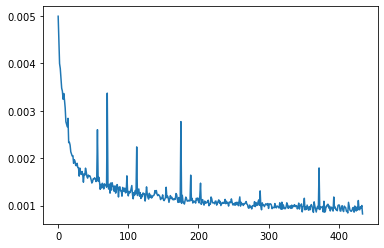

  0%|          | 0/1405 [00:00<?, ?it/s]

87200 :  0.0009186912168911423
87400 :  0.0008526050116298303
87600 :  0.0008930596152292074
87800 :  0.0009127672320078508
88000 :  0.0009535721399906577
88200 :  0.0008890147611697672
88400 :  0.0009028625036044184
Tokens
              precision    recall  f1-score   support

           O       0.99      0.99      0.99    169578
         PER       0.89      0.90      0.90     11128
         ORG       0.78      0.76      0.77     10025
         LOC       0.83      0.83      0.83      8297
        MISC       0.76      0.63      0.69      4593

    accuracy                           0.96    203621
   macro avg       0.85      0.82      0.84    203621
weighted avg       0.96      0.96      0.96    203621

Tokens
              precision    recall  f1-score   support

           O       0.99      1.00      0.99     42759
         PER       0.92      0.96      0.94      3149
         ORG       0.87      0.78      0.82      2092
         LOC       0.86      0.93      0.90      2094
        M

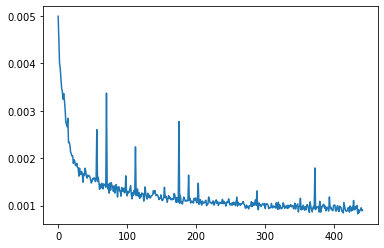

  0%|          | 0/1405 [00:00<?, ?it/s]

88600 :  0.0011940404400034227
88800 :  0.0008774247610957641
89000 :  0.0009132500792452912
89200 :  0.0009150440194867518
89400 :  0.0008191716633345439
89600 :  0.0009482219804136284
89800 :  0.0009183723654148845
Tokens
              precision    recall  f1-score   support

           O       0.99      0.99      0.99    169578
         PER       0.89      0.91      0.90     11128
         ORG       0.78      0.76      0.77     10025
         LOC       0.82      0.82      0.82      8297
        MISC       0.75      0.62      0.68      4593

    accuracy                           0.96    203621
   macro avg       0.85      0.82      0.83    203621
weighted avg       0.96      0.96      0.96    203621

Tokens
              precision    recall  f1-score   support

           O       0.99      1.00      0.99     42759
         PER       0.92      0.96      0.94      3149
         ORG       0.86      0.81      0.83      2092
         LOC       0.89      0.92      0.91      2094
        M

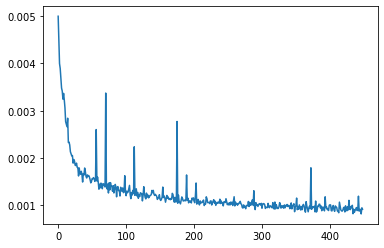

  0%|          | 0/1405 [00:00<?, ?it/s]

90000 :  0.0008258447340808834
90200 :  0.0008908697873160848
90400 :  0.0009260442308881554
90600 :  0.0008945204260393412
90800 :  0.0009780626677140824
91000 :  0.0009381443429453321
91200 :  0.0009817760870585845
Tokens
              precision    recall  f1-score   support

           O       0.99      0.99      0.99    169578
         PER       0.89      0.90      0.89     11128
         ORG       0.78      0.76      0.77     10025
         LOC       0.83      0.83      0.83      8297
        MISC       0.76      0.64      0.69      4593

    accuracy                           0.96    203621
   macro avg       0.85      0.83      0.84    203621
weighted avg       0.96      0.96      0.96    203621

Tokens
              precision    recall  f1-score   support

           O       0.99      1.00      0.99     42759
         PER       0.91      0.96      0.94      3149
         ORG       0.87      0.79      0.83      2092
         LOC       0.89      0.92      0.91      2094
        M

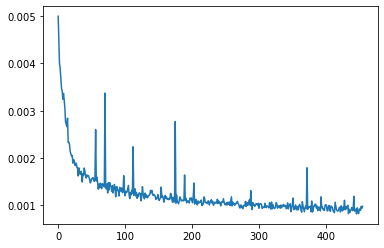

  0%|          | 0/1405 [00:00<?, ?it/s]

91400 :  0.0009445018796302067
91600 :  0.0009107880654140145
91800 :  0.0009810391410776454
92000 :  0.0008554330607209789
92200 :  0.0008621741866381954
92400 :  0.0009287664302971125
92600 :  0.0008454025354871878
Tokens
              precision    recall  f1-score   support

           O       0.99      0.99      0.99    169578
         PER       0.89      0.90      0.89     11128
         ORG       0.78      0.75      0.77     10025
         LOC       0.82      0.83      0.82      8297
        MISC       0.75      0.63      0.68      4593

    accuracy                           0.96    203621
   macro avg       0.84      0.82      0.83    203621
weighted avg       0.96      0.96      0.96    203621

Tokens
              precision    recall  f1-score   support

           O       0.99      1.00      0.99     42759
         PER       0.92      0.96      0.94      3149
         ORG       0.86      0.80      0.83      2092
         LOC       0.89      0.91      0.90      2094
        M

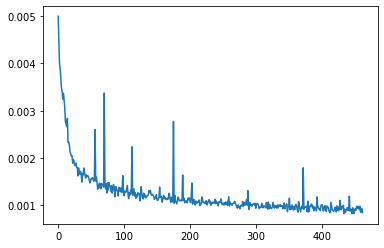

  0%|          | 0/1405 [00:00<?, ?it/s]

92800 :  0.0009059416890956183
93000 :  0.0008450046023842431
93200 :  0.0009587506733331305
93400 :  0.0009250694049953869
93600 :  0.0009255274575551221
93800 :  0.0009971438988335415
94000 :  0.0008151335633229238
Tokens
              precision    recall  f1-score   support

           O       0.99      0.99      0.99    169578
         PER       0.89      0.90      0.89     11128
         ORG       0.78      0.76      0.77     10025
         LOC       0.82      0.82      0.82      8297
        MISC       0.75      0.64      0.69      4593

    accuracy                           0.96    203621
   macro avg       0.85      0.82      0.83    203621
weighted avg       0.96      0.96      0.96    203621

Tokens
              precision    recall  f1-score   support

           O       0.99      1.00      0.99     42759
         PER       0.91      0.97      0.94      3149
         ORG       0.85      0.80      0.82      2092
         LOC       0.90      0.91      0.91      2094
        M

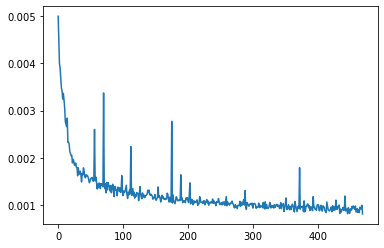

  0%|          | 0/1405 [00:00<?, ?it/s]

94200 :  0.0009325630594943474
94400 :  0.000832434467746931
94600 :  0.0009905438121979584
94800 :  0.0008804113900804984
95000 :  0.0009010700417629268
95200 :  0.0008818763239190533
95400 :  0.0008847055110294469
Tokens
              precision    recall  f1-score   support

           O       0.99      0.99      0.99    169578
         PER       0.89      0.91      0.90     11128
         ORG       0.78      0.76      0.77     10025
         LOC       0.83      0.83      0.83      8297
        MISC       0.75      0.64      0.69      4593

    accuracy                           0.96    203621
   macro avg       0.85      0.83      0.84    203621
weighted avg       0.96      0.96      0.96    203621

Tokens
              precision    recall  f1-score   support

           O       0.99      1.00      0.99     42759
         PER       0.93      0.96      0.94      3149
         ORG       0.87      0.79      0.83      2092
         LOC       0.88      0.93      0.90      2094
        MI

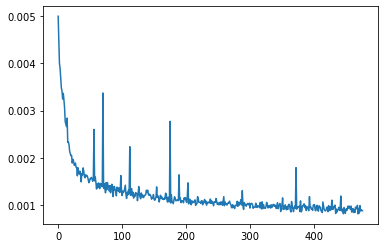

  0%|          | 0/1405 [00:00<?, ?it/s]

95600 :  0.0009095149515160471
95800 :  0.0008853171873699615
96000 :  0.0008683376838582231
96200 :  0.0009192953460562376
96400 :  0.0009301160016774976
96600 :  0.0009561551653845109
96800 :  0.0008331092576510522
Tokens
              precision    recall  f1-score   support

           O       0.99      0.99      0.99    169578
         PER       0.89      0.90      0.90     11128
         ORG       0.78      0.77      0.78     10025
         LOC       0.83      0.83      0.83      8297
        MISC       0.75      0.63      0.69      4593

    accuracy                           0.96    203621
   macro avg       0.85      0.83      0.84    203621
weighted avg       0.96      0.96      0.96    203621

Tokens
              precision    recall  f1-score   support

           O       0.99      1.00      0.99     42759
         PER       0.91      0.96      0.93      3149
         ORG       0.86      0.79      0.82      2092
         LOC       0.89      0.92      0.90      2094
        M

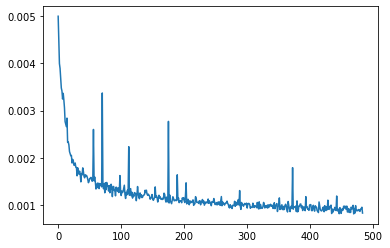

  0%|          | 0/1405 [00:00<?, ?it/s]

97000 :  0.0010486977869589003
97200 :  0.0008677238589672777
97400 :  0.0008455760092024015
97600 :  0.0009430351037441802
97800 :  0.0008703432071474396
98000 :  0.000955341685692478
98200 :  0.0009241822590766874
Tokens
              precision    recall  f1-score   support

           O       0.99      0.99      0.99    169578
         PER       0.89      0.91      0.90     11128
         ORG       0.79      0.77      0.78     10025
         LOC       0.83      0.83      0.83      8297
        MISC       0.75      0.64      0.69      4593

    accuracy                           0.96    203621
   macro avg       0.85      0.83      0.84    203621
weighted avg       0.96      0.96      0.96    203621

Tokens
              precision    recall  f1-score   support

           O       0.99      1.00      0.99     42759
         PER       0.91      0.97      0.94      3149
         ORG       0.84      0.81      0.83      2092
         LOC       0.91      0.91      0.91      2094
        MI

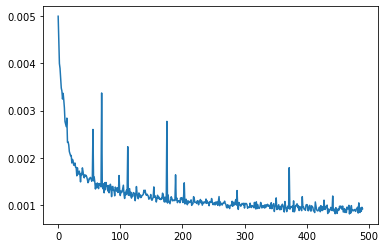

  0%|          | 0/1405 [00:00<?, ?it/s]

98400 :  0.0008958649760323949
98600 :  0.0009456201576818874
98800 :  0.0009298203698071762
99000 :  0.0008992142528428837
99200 :  0.0008075394374944485
99400 :  0.0008669058823280086
99600 :  0.0009478073768781168
Tokens
              precision    recall  f1-score   support

           O       0.99      0.99      0.99    169578
         PER       0.89      0.91      0.90     11128
         ORG       0.78      0.76      0.77     10025
         LOC       0.83      0.83      0.83      8297
        MISC       0.76      0.64      0.69      4593

    accuracy                           0.96    203621
   macro avg       0.85      0.83      0.84    203621
weighted avg       0.96      0.96      0.96    203621

Tokens
              precision    recall  f1-score   support

           O       0.99      1.00      0.99     42759
         PER       0.92      0.97      0.94      3149
         ORG       0.89      0.79      0.83      2092
         LOC       0.90      0.92      0.91      2094
        M

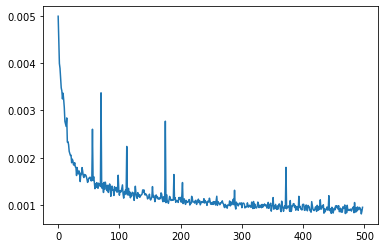

  0%|          | 0/1405 [00:00<?, ?it/s]

99800 :  0.0009088736108142882
100000 :  0.0008494350843972361
100200 :  0.0009307615728952474
100400 :  0.0008960186584275521
100600 :  0.0008591142140518303
100800 :  0.0008637307429120609
101000 :  0.0009300686591848155
Tokens
              precision    recall  f1-score   support

           O       0.99      0.99      0.99    169578
         PER       0.89      0.91      0.90     11128
         ORG       0.79      0.77      0.78     10025
         LOC       0.83      0.83      0.83      8297
        MISC       0.76      0.64      0.70      4593

    accuracy                           0.96    203621
   macro avg       0.85      0.83      0.84    203621
weighted avg       0.96      0.96      0.96    203621

Tokens
              precision    recall  f1-score   support

           O       0.99      1.00      0.99     42759
         PER       0.92      0.96      0.94      3149
         ORG       0.86      0.81      0.83      2092
         LOC       0.90      0.92      0.91      2094
   

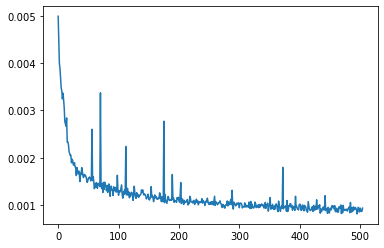

  0%|          | 0/1405 [00:00<?, ?it/s]

101200 :  0.0009045502756715016
101400 :  0.000957545917700398
101600 :  0.0009045228284758678
101800 :  0.0008600966197870809
102000 :  0.0008050722831281324
102200 :  0.0008944333777053344
102400 :  0.000847519991185179
Tokens
              precision    recall  f1-score   support

           O       0.99      0.99      0.99    169578
         PER       0.89      0.90      0.90     11128
         ORG       0.79      0.77      0.78     10025
         LOC       0.83      0.83      0.83      8297
        MISC       0.76      0.65      0.70      4593

    accuracy                           0.96    203621
   macro avg       0.85      0.83      0.84    203621
weighted avg       0.96      0.96      0.96    203621

Tokens
              precision    recall  f1-score   support

           O       0.99      1.00      0.99     42759
         PER       0.92      0.96      0.94      3149
         ORG       0.83      0.84      0.83      2092
         LOC       0.92      0.90      0.91      2094
    

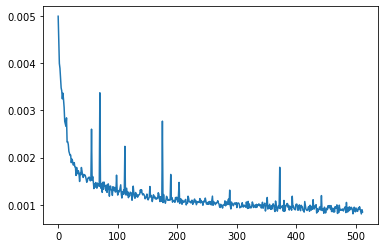

  0%|          | 0/1405 [00:00<?, ?it/s]

102600 :  0.0009350980427098956
102800 :  0.0008915245252633797
103000 :  0.0008954715520839983
103200 :  0.0008900565665480929
103400 :  0.0008473186861896466
103600 :  0.0008777426590168334
103800 :  0.0008923964657785344
Tokens
              precision    recall  f1-score   support

           O       0.99      0.99      0.99    169578
         PER       0.89      0.91      0.90     11128
         ORG       0.79      0.77      0.78     10025
         LOC       0.84      0.83      0.83      8297
        MISC       0.77      0.66      0.71      4593

    accuracy                           0.96    203621
   macro avg       0.85      0.83      0.84    203621
weighted avg       0.96      0.96      0.96    203621

Tokens
              precision    recall  f1-score   support

           O       0.99      1.00      0.99     42759
         PER       0.92      0.96      0.94      3149
         ORG       0.84      0.83      0.84      2092
         LOC       0.91      0.91      0.91      2094
  

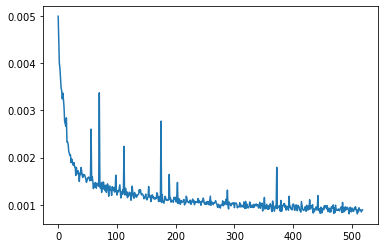

  0%|          | 0/1405 [00:00<?, ?it/s]

104000 :  0.0008858147443833864
104200 :  0.0009046952668061525
104400 :  0.0009455768054415768
104600 :  0.0007872372461753542
104800 :  0.00089057974019445
105000 :  0.0009571384886635435
105200 :  0.000917836048486185
Tokens
              precision    recall  f1-score   support

           O       0.99      0.99      0.99    169578
         PER       0.89      0.91      0.90     11128
         ORG       0.78      0.76      0.77     10025
         LOC       0.84      0.83      0.83      8297
        MISC       0.76      0.65      0.70      4593

    accuracy                           0.96    203621
   macro avg       0.85      0.83      0.84    203621
weighted avg       0.96      0.96      0.96    203621

Tokens
              precision    recall  f1-score   support

           O       0.99      1.00      0.99     42759
         PER       0.90      0.97      0.93      3149
         ORG       0.89      0.78      0.83      2092
         LOC       0.90      0.91      0.91      2094
     

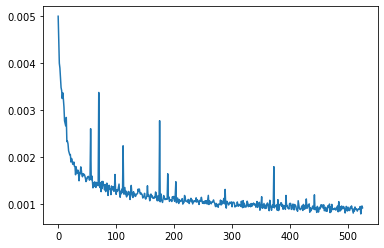

  0%|          | 0/1405 [00:00<?, ?it/s]

105400 :  0.0009413697480386922
105600 :  0.0008493625130998604
105800 :  0.0008705786265987172
106000 :  0.0009012688081619439
106200 :  0.0009823909616668493
106400 :  0.0009128936947924452
106600 :  0.0008524212274394073
Tokens
              precision    recall  f1-score   support

           O       0.99      0.99      0.99    169578
         PER       0.89      0.91      0.90     11128
         ORG       0.78      0.76      0.77     10025
         LOC       0.83      0.83      0.83      8297
        MISC       0.76      0.64      0.70      4593

    accuracy                           0.96    203621
   macro avg       0.85      0.83      0.84    203621
weighted avg       0.96      0.96      0.96    203621

Tokens
              precision    recall  f1-score   support

           O       0.99      1.00      0.99     42759
         PER       0.93      0.96      0.94      3149
         ORG       0.83      0.84      0.83      2092
         LOC       0.92      0.91      0.91      2094
  

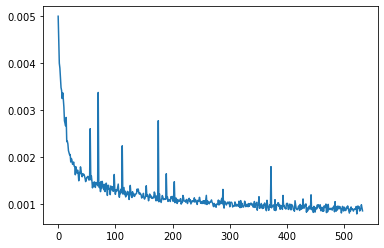

  0%|          | 0/1405 [00:00<?, ?it/s]

106800 :  0.0008957098757433181
107000 :  0.0008833096318620565
107200 :  0.0008930169326948071
107400 :  0.0009410969342587084
107600 :  0.0009921539303832233
107800 :  0.0008001957518934483
108000 :  0.0008640319047580128
Tokens
              precision    recall  f1-score   support

           O       0.99      0.99      0.99    169578
         PER       0.89      0.91      0.90     11128
         ORG       0.79      0.77      0.78     10025
         LOC       0.83      0.83      0.83      8297
        MISC       0.76      0.65      0.70      4593

    accuracy                           0.96    203621
   macro avg       0.85      0.83      0.84    203621
weighted avg       0.96      0.96      0.96    203621

Tokens
              precision    recall  f1-score   support

           O       0.99      1.00      0.99     42759
         PER       0.91      0.97      0.94      3149
         ORG       0.85      0.81      0.83      2092
         LOC       0.91      0.91      0.91      2094
  

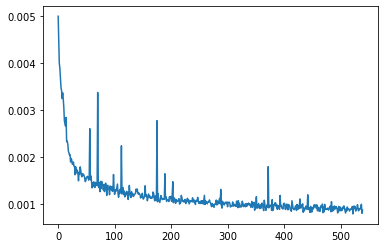

  0%|          | 0/1405 [00:00<?, ?it/s]

108200 :  0.0009442019787198639
108400 :  0.0008990100811141256
108600 :  0.0008242238938330779
108800 :  0.0008644781923391178
109000 :  0.000872501800348611
109200 :  0.0008557166449787405
109400 :  0.0009004831624268253
Tokens
              precision    recall  f1-score   support

           O       0.99      0.99      0.99    169578
         PER       0.89      0.91      0.90     11128
         ORG       0.79      0.77      0.78     10025
         LOC       0.84      0.84      0.84      8297
        MISC       0.76      0.65      0.70      4593

    accuracy                           0.96    203621
   macro avg       0.85      0.83      0.84    203621
weighted avg       0.96      0.96      0.96    203621

Tokens
              precision    recall  f1-score   support

           O       0.99      1.00      0.99     42759
         PER       0.91      0.97      0.94      3149
         ORG       0.87      0.80      0.83      2092
         LOC       0.90      0.92      0.91      2094
   

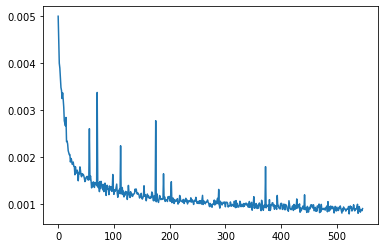

  0%|          | 0/1405 [00:00<?, ?it/s]

109600 :  0.0008236509070669946
109800 :  0.0009055420081149217
110000 :  0.0008557287486949769
110200 :  0.0008787511712445821
110400 :  0.0008927918198348264
110600 :  0.000837766583665452
110800 :  0.0008895831834022515
Tokens
              precision    recall  f1-score   support

           O       0.99      0.99      0.99    169578
         PER       0.89      0.91      0.90     11128
         ORG       0.79      0.77      0.78     10025
         LOC       0.83      0.83      0.83      8297
        MISC       0.76      0.64      0.70      4593

    accuracy                           0.96    203621
   macro avg       0.85      0.83      0.84    203621
weighted avg       0.96      0.96      0.96    203621

Tokens
              precision    recall  f1-score   support

           O       0.99      1.00      0.99     42759
         PER       0.91      0.96      0.94      3149
         ORG       0.88      0.80      0.84      2092
         LOC       0.89      0.93      0.91      2094
   

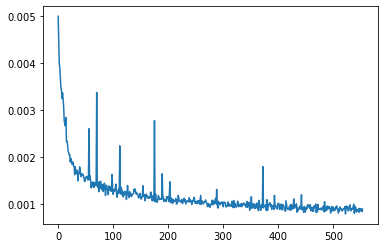

  0%|          | 0/1405 [00:00<?, ?it/s]

111000 :  0.0009254016197925813
111200 :  0.0008963716013323364
111400 :  0.0008570917277466665
111600 :  0.0008304953324323272
111800 :  0.0008545685823116596
112000 :  0.0009136395908635091
112200 :  0.0008823510692427059
112400 :  0.0008580690618399502
Tokens
              precision    recall  f1-score   support

           O       0.99      0.99      0.99    169578
         PER       0.90      0.91      0.90     11128
         ORG       0.79      0.77      0.78     10025
         LOC       0.84      0.83      0.84      8297
        MISC       0.78      0.66      0.71      4593

    accuracy                           0.96    203621
   macro avg       0.86      0.83      0.84    203621
weighted avg       0.96      0.96      0.96    203621

Tokens
              precision    recall  f1-score   support

           O       0.99      1.00      0.99     42759
         PER       0.91      0.97      0.94      3149
         ORG       0.88      0.79      0.83      2092
         LOC       0.91 

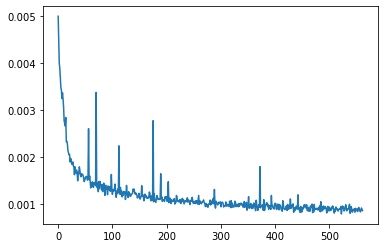

In [69]:
lossses = train(
    model,
    optimizer,
    train_dataloader,
    test_dataloader,
    valid_dataloader,
    id_to_tag,
    number_of_epochs,
    use_gpu=USE_GPU
)

<ipython-input-16-d18636477f2b>:13: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  sentence_features = torch.LongTensor(self.data[index]['words_features'])


Tokens
              precision    recall  f1-score   support

           O       0.99      0.99      0.99     38323
         PER       0.91      0.97      0.94      2773
         ORG       0.86      0.77      0.81      2496
         LOC       0.83      0.87      0.85      1925
        MISC       0.78      0.72      0.75       918

    accuracy                           0.97     46435
   macro avg       0.87      0.86      0.87     46435
weighted avg       0.97      0.97      0.97     46435

Spans
{'spans precision': 0.810361216730038, 'spans recall': 0.8617639625979278, 'spans f1': 0.8352725045927741, 'spans accuracy': 0.9681274900398407}


[3.326899898849954e-05,
 3.4488281673941935e-05,
 3.541538602001565e-05,
 2.9407418748762992e-05,
 2.3113199297273367e-05,
 0.00010455971110671286,
 0.00010292596562067047,
 8.78301573296388e-05,
 8.901705134760689e-05,
 0.00010624615806004693,
 0.0001097876966620485,
 6.72169571400297e-05,
 8.445207435542192e-05,
 8.132421974966555e-05,
 3.968229999833078e-05,
 3.8521998828788944e-05,
 8.901705134760689e-05,
 8.554885454185598e-05,
 8.234077249653637e-05,
 2.4579335073592946e-05,
 1.7109770908371195e-05,
 3.413089015400471e-05,
 7.00772531885416e-05,
 4.1429319495112644e-05,
 3.4488281673941935e-05,
 0.0001013424892265063,
 9.023646300990287e-05,
 0.00012916199607299823,
 5.8814837497525983e-05,
 4.990349848274932e-05,
 2.4579335073592946e-05,
 2.9018774448118545e-05,
 7.485524772412397e-05,
 7.238749230464736e-05,
 5.355497398148707e-05,
 9.980699696549864e-05,
 0.00010455971110671286,
 0.00010455971110671286,
 0.0001013424892265063,
 0.0001317452359944582,
 0.00010292596562067047,
 